<a href="https://colab.research.google.com/github/mheeniac/lstm_fdi/blob/master/tf_1_14_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict PROBA-V AOCS faults using LSTM and keras (TPU)

## Overview

This file uses [tf.keras](https://www.tensorflow.org/guide/keras) and an LSTM network to predict AOCS faults. It uses TPUs to accelerate the training time of the network.

<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 
   
TPUs are located in Google Cloud, for optimal performance, they read data directly from Google Cloud Storage (GCS). 

This script assumes the test data is located on a Google Drive: gdrive/My Drive/data/training/ or gdrive/My Drive/data/testing 


## Data, Model, and Training

This section includes the data, model, and training

### Settings

The settings used for the simulation

In [0]:
import numpy as np

DEBUG = False   # Se to True for debugging mode. Changing this value requires the runtime to restart
RELOAD = False  # Se to true of the raw files should be reloaded from disk. False will use a saved .pkl file 
VAL = False     # If validation set should be run during the training session
NAME = "lstm_all_with_stardiv" # Name of the settings/run

# A list of features to be exluded. Possible values (or None): 
# ['kal', 'kalq', 'kaldiv', 'kalref', star', 'star1', 'star2', wheel', 'mt', 'mt1', 'mt2', 'omega', 'gps', 'gpospos'
#   , 'gpsvel', 'current', 'wheel']
EXCLUDE_FEATURES = []

# Number of timesteps in the sequence
SEQ_LEN = 32

# Which classes to include
INCLUDE = np.arange(1,35)
INCLUDE = np.insert(INCLUDE,0,0)    

# Number of faults/classes
NUM_CLASSES = 35

# Number of units in the LSTM
NUM_UNITS = [512, 512]   

# The batch size
BATCH_SIZE = 1024

# Number of training epochs
NUM_EPOCHS = 80

# The learning rate
LR = 0.001

# Index of the first feature column
START = 3

settings =  {'EXCLUDE_FEATURES': EXCLUDE_FEATURES,
             'SEQ_LEN': SEQ_LEN,
             'INCLUDE': INCLUDE,
             'NUM_CLASSES': NUM_CLASSES,
             'NUM_UNITS': NUM_UNITS,
             'BATCH_SIZE': BATCH_SIZE,
             'NUM_EPOCHS': NUM_EPOCHS,
             'LR': LR,
             'START': START}

###Imports

This following code block handles the imports, checks for the correct tf version (1.14), sets the TPU_worker, and mounts the drive. 

Follow the url link promted in the output and copy the code to link your drive.

In [0]:
#!pip install tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [0]:
import pandas as pd
import numpy as np
import six
import os
import csv
import tensorflow as tf

# if DEBUG:
#   tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
import pickle

from pathlib import Path
from tensorflow.keras.utils import plot_model
from google.colab import drive
from shutil import copy2
from tqdm import tqdm_notebook as tqdm
from time import time
from matplotlib import pyplot as plt
from contextlib import redirect_stdout
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

if tf.__version__.split('.')[1] == '13':
  raise Exception('This notebook is not compatible with TF 1.13')
  
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print(TPU_WORKER)
# Mounting the drive
drive.mount('/content/gdrive')

with open(Path('gdrive/My Drive/data/result/{0}.txt'.format(NAME)), 'w') as f:
  for key, value in settings.items():
    f.write("{0} = {1}\n".format(key,value))

folder = 'training'
source = Path('gdrive/My Drive/data/{0}'.format(folder))
files = [f for f in source.glob('**/*/kal*') if f.is_file()]
files[0:5]

TensorFlow version: 1.14.0
Eager execution: False
grpc://10.66.108.106:8470
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[PosixPath('gdrive/My Drive/data/training/03-07/kaldiv_1r1.txt'),
 PosixPath('gdrive/My Drive/data/training/03-07/kaldiv_2r1.txt'),
 PosixPath('gdrive/My Drive/data/training/03-07/kaldiv_3r1.txt'),
 PosixPath('gdrive/My Drive/data/training/03-07/kaldiv_4r1.txt'),
 PosixPath('gdrive/My Drive/data/training/03-07/kaldiv_5r1.txt')]

###Loading Data

Data is loaded using the load_files function. The number of files can be set using n, e.g. for debugging purposes when a small number of files is wanted. A subfolder can be given to denote e.g. trianing or testing data. 

#### Training and Testing set

In [0]:
def load_files(n=None, folder='training', reload=False):
  if RELOAD:
    # First load the header file
    with open('gdrive/My Drive/data/{0}/header.txt'.format(folder), 'r') as csvfile:
      readCSV = csv.reader(csvfile, delimiter=',')
      for row in readCSV:
        header = row
        
    source = Path('gdrive/My Drive/data/{0}'.format(folder))
    files = [f for f in source.glob('**/**/kal*') if f.is_file()]
    dfs = []
    for name in tqdm(files[0:n]):
      dfs.append(pd.read_csv(name,names=header))
    df = pd.concat(dfs, sort=False)
    df.to_pickle(Path('gdrive/My Drive/data/{0}.pkl'.format(folder)))
  else:
    df = pd.read_pickle(Path('gdrive/My Drive/data/{0}.pkl'.format(folder)))
  return df
df_train = load_files(n = 5 if DEBUG else None,folder='28-Sep-2019', reload = RELOAD)
df_test = load_files(n = 5 if DEBUG else None,folder='27-Sep-2019', reload = RELOAD)

#### Scaling The Data
The different features have a large variation in range, all attitude information for example is normalised and ranges between -1 and 1. Whereas the position ranges from -a to +a (a = roughly 7200 km). 

The datasets are then saved to disk, so the TPU can load them dynamically. 

In [0]:
def scale_data(data, exclude=None):
  # Scaling dictionary
  scaling = {'pos': 7.2e6,
            'vel': 7.35e3,
            'wheelspeeds': 294,
            'mt': 0.0000455,
            'commanded': 0.05,
            'wheelCurrent':0.2,
            'omega': 1.8e-3}
  # Creating a copy of the original dataframe
  df_scaled = data.copy()

  # Drop the features that are not wanted 
  if exclude: # If None, then no need to drop any
    cols = [] # Will be populated with the columns to keep
    for col in df_scaled.columns:
      keep = True # Keep column unless exclude column found
      for keys in exclude:  # Loop over the exclude keys
        if keys in col.lower() and 'start' not in col.lower(): # Check if the key is in the column name
          keep = False
          break
      if keep:  # Not an exclude column, append to list to keep
        cols.append(col)
    df_scaled = df_scaled[cols] # New scaled data with only desired columns   

  # Looping over the scaling dictionary
  for k,v in tqdm(scaling.items()):
    keys = df_scaled.filter(like=k).keys()
    df_scaled[keys] = df_scaled[keys]/v

  # When sensors crashed, no data was available. However, the network cannot handle NaN
  df_scaled.fillna(0, inplace=True)

  try:
    df_scaled['stardiv'] = ((df_scaled['star1'] - df_scaled['star2'])**2 + (df_scaled['star1.1'] - df_scaled['star2.1'])**2 + (df_scaled['star1.2'] - df_scaled['star2.2'])**2)**0.5
  except:
    print("Could not create the stardiv feature, star might not be defined")

  try:
    df_scaled['mtdiv'] = ((df_scaled['mt1'] - df_scaled['mt2'])**2 + (df_scaled['mt1.1'] - df_scaled['mt2.1'])**2 + (df_scaled['mt1.2'] - df_scaled['mt2.2'])**2)**0.5
  except:
    print("Could not create the mtdiv feature, mt might not be defined")

  # Because panda dataframes are very slow to retrieve values as numpy arrays
  # the dataframe is converted into a numpy array
  np_scaled = df_scaled.values
  n_features = len(df_scaled.columns)-3
  return np_scaled, df_scaled, n_features

np_train, dfs_train, NUM_FEATURES = scale_data(df_train, exclude=EXCLUDE_FEATURES)
np_test, _, _ = scale_data(df_test, exclude=EXCLUDE_FEATURES)

with open('/content/train.npy', 'wb') as f:
  np.save(f, np_train)
  
with open('/content/test.npy', 'wb', True) as f:
  np.save(f, np_test)

In [0]:
print("The data has {0} features".format(NUM_FEATURES))
dfs_train.head()

The data has 52 features


time  class  fault_start  ...  wheelCurrent.2   stardiv     mtdiv
0  220.00     10          449  ...        0.121901  0.000091  0.019930
1  220.25     10          449  ...        0.114170  0.000057  0.033416
2  220.50     10          449  ...        0.112881  0.000053  0.021054
3  220.75     10          449  ...        0.115611  0.000064  0.005703
4  221.00     10          449  ...        0.119735  0.000053  0.017607

[5 rows x 55 columns]

### Sample Generation

Not all indices are valid indices, as the dataset is composed of multiple simulation sessions stacked end to start. The below function generates the valid indices and corresponding labels. The function can be set to exclude nominal scenarios, or undersample to make the number of samples per class more equal. 

In [0]:
def valid_indices(data, seq_len=32, undersample=True, include_list=np.arange(35), n_classes=35):
  fault_dict = {0: 'Nominal', 1: 'ST1 Freeze', 2: 'ST1 BO', 3: 'ST1 MA',
             4: 'ST2 Freeze', 5: 'ST2 BO', 6: 'ST2 MA',
             7: 'MT1 Freeze', 8: 'MT1 BO', 9: 'MT1 MA',
             10: 'MT2 Freeze', 11: 'MT2 BO', 12: 'MT2 MA',
             13: 'GPS Freeze', 14: 'GPS BO',
             15: 'RW1 Friction', 16: 'RW1 Electrical', 17: 'RW1 Freeze',  18: 'RW1 PO',
             19: 'RW1 MA', 20: 'RW1 Tachometer',
             21: 'RW2 Friction', 22: 'RW2 Electrical', 23: 'RW2 Freeze', 24: 'RW2 PO',
             25: 'RW2 MA', 26: 'RW2 Tachometer',
             27: 'RW3 Friction', 28: 'RW3 Electrical', 29: 'RW3 Freeze',  30: 'RW3 PO',
             31: 'RW3 MA', 32: 'RW3 Tachometer',
             33: 'ST1&2 Freeze', 34: 'ST1&2 BO'}
  
  indices = np.arange(0, data.shape[0]-seq_len)
  labels = {idx: [] for idx in indices} # An empty dictionary to store the future classes/labels

  # Some indices would contain a sample that crosses over from one simulation to the next
  # This would be the case where the class at t_0 does not equal the class at t_n
  idxs_del = [] # indices to be deleted
  for idx in tqdm(indices):
    # Check for class discontinuity
    if data[idx+seq_len][1] != data[idx][1]:
      # Invalid sample, append to deletion index
      idxs_del.append(idx)
    else:
      # Valid sample, determine the label
      if 'MA' not in fault_dict[data[idx][1]]: # Check if it is an MA fault
        # Non MA Fault, check if t_n > fault_start
        labels[idx] = data[idx][1] if (data[idx+seq_len][0] > data[idx][2]) else 0
      else:
        # MA fault, no need to check time
        labels[idx] = data[idx][1]
  # Delete the unwanted indices
  [labels.pop(e) for e in idxs_del]
  labels_old = labels
  
  # Remove the samples that are not in the desired classes include list
  if any(include_list):
    exclude = [int(x) for x, v in labels.items() if v not in include_list] # Getting the non included sample indices
    for e in exclude:
      labels.pop(e) # Removing the undesired indeces
      
  # Undersample the data if undersample == True
  if undersample:
    X = [x for x in labels.keys()]
    y = [y for y in labels.values()]
    X = np.array(X) # Convert to numpy array
    X = X.reshape(-1,1)# Reshape because RandomUnderSampler requires 2D array

    rus = RandomUnderSampler(random_state=0) # initiate undersampler object
    X_resampled, y_resampled = rus.fit_resample(X, y) # resample data
    
    labels = dict() # Empty labels dict
    labels = {int(idx): int(label) for idx, label in zip(X_resampled.flatten(), y_resampled)} # Recreate the labels dict from resampled data
  else:
    X = [x for x in labels.keys()]
    y = [y for y in labels.values()]
    labels = dict() # Empty labels dict
    labels = {int(idx): int(label) for idx, label in zip(X, y)} # Recreate the labels dict from resampled data
  indices = [k for k in labels.keys()] # Create the indices from the dictionary keys
  for idx, lab in labels.items():
    if lab != labels_old[idx]:
      raise ValueError('There is a mismatch between the labels!')
  return indices, labels

### Input function

This function creates a tensorflow dataset including all the valid samples. 

In [0]:
def input_fn(seq_len=32, batch_size=1024, num_classes = 35, num_epochs=10, dtype='train', shuffle=True, start=3, 
            num_features=50):
  # Load data
  with tf.io.gfile.GFile('/content/{0}.npy'.format(dtype), 'rb') as f:
    data = np.load(f)
  # Load indices
  with tf.io.gfile.GFile('/content/{0}_indices.npy'.format(dtype), 'rb') as f:
    indices = np.load(f)
  # Load labels
  with tf.io.gfile.GFile('/content/{0}_labels.pkl'.format(dtype), 'rb') as f:
    label_dict = pickle.load(f)
  labels = [x for x in label_dict.values()]

  if shuffle:
    arr = np.arange(len(indices))
    np.random.shuffle(arr)
    indices = indices[arr]
    labels = np.array(labels)[arr]
  # Create constants
  labels = tf.constant(labels, dtype=tf.int32)
  indices = tf.constant(indices, dtype=tf.int32)
  data = tf.constant(data, dtype=tf.float32)
  # Construct dataset
  ds = tf.data.Dataset.from_tensor_slices(indices)
  
  # Map dataset as sequence of length seq_len and labels
  ds1 = ds.map(lambda x: tf.slice(data, [x, start], [seq_len, num_features]))
  ds2 = tf.data.Dataset.from_tensor_slices(labels)

  ds3 = tf.data.Dataset.zip((ds1,ds2.map(lambda x: tf.one_hot(tf.cast(x, dtype=tf.int32), depth=num_classes)),ds))
  # # Shuffle and batch the data with buffer of 10x the batch size, repeat for the num of epochs
  if shuffle:
    ds3 = ds3.shuffle(10 * batch_size).repeat(num_epochs).batch(batch_size, drop_remainder=True)
  else:
    ds3 = ds3.repeat(num_epochs).batch(batch_size, drop_remainder=True)
  return ds3.map(lambda a,b,c: (a,b)), ds3.map(lambda a,b,c: c)

#### Verification

In [0]:
if DEBUG:
  indices, labels = valid_indices(np_train, seq_len=SEQ_LEN, include_list=INCLUDE, undersample=True)
  with open('/content/train_indices.npy', 'wb') as f:
    np.save(f, indices)

  with open("train_labels.pkl", 'wb') as f:
    pickle.dump(labels,f)
  
  # A sanity check to see if the data makes sense
  FAULT = 1
  PLOT = ['star1', 'star1.1']

  # Find an index corresponding to FAULT
  twoIdx = (list(labels.keys())[list(labels.values()).index(FAULT)])
  # Plot the data belonging to that fault
  df_train.iloc[twoIdx-5:twoIdx+SEQ_LEN+5][PLOT].plot()

In [0]:
if DEBUG and tf.executing_eagerly():
  print("Non-Shuffled Data:")
  ds = tf.data.Dataset.from_tensor_slices(np.arange(0,10))
  ds = ds.batch(3,drop_remainder=True).repeat(3)
  i = 1
  for x in ds:
    print(x)
    if i%3 == 0:
      print("Finished Epoch {0}".format(i/3))
    i = i + 1
  print("\nShuffled Data:")
  ds = tf.data.Dataset.from_tensor_slices(np.arange(0,10))
  ds = ds.shuffle(30).batch(3,drop_remainder=True).repeat(3)
  i = 1
  for x in ds:
    print(x)
    if i%3 == 0:
      print("Finished Epoch {0}".format(i/3))
    i = i + 1

In [0]:
 if DEBUG and tf.executing_eagerly():
  ds, _ = input_fn(seq_len=SEQ_LEN, batch_size=1024, num_epochs=1, num_classes=NUM_CLASSES, 
                                      start=START, num_features=NUM_FEATURES, shuffle=False)
  i = 0
  nErrors = 0
  for x, y in tqdm(ds):
    for label in tqdm(y.numpy()):
      if np.argmax(label, axis=0) != labels[indices[i]]:
        print("Error at i={0}".format(i))
        print("Label = {0}".format(np.argmax(label, axis=0)))
        nErrors = nErrors + 1
      i = i + 1
  print("Checked {0} labels and found {1} mismatches.".format(i, nErrors))
  #np_train[indices[0]][START:START+NUM_FEATURES]

### LSTM model

In [0]:
def lstm_model(seq_len=32, batch_size=None, stateful=True, n_features=50, num_classes=35, 
              num_units=[32, 32]):
  source = tf.keras.Input(
  name='seed', shape=(seq_len, n_features), 
      batch_size=batch_size)
  
  lstm_1 = tf.keras.layers.LSTM(num_units[0], stateful=stateful, return_sequences=True,dropout=0.1, recurrent_dropout=0.1)(source)
  lstm_2 = tf.keras.layers.LSTM(num_units[1], stateful=stateful, return_sequences=False, dropout=0.1)(lstm_1)
  #dense_1 = tf.keras.layers.Dense(100, activation='relu')(lstm_2)
  
  predict = tf.keras.layers.Dense(num_classes, activation='softmax')(lstm_2)
  
  return tf.keras.Model(inputs=[source], outputs=[predict])

In [0]:
def conv1D_model(seq_len, batch_size=None, n_features=50, num_classes=35, num_filters=64):
  source = tf.keras.Input(name='seed', shape=(seq_len, n_features),
                         batch_size=batch_size)
  
  conv_1 = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='relu')(source)
  conv_2 = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='relu')(conv_1)
  drop_1 = tf.keras.layers.Dropout(0.5)(conv_2)
  pool_1 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop_1)
  flat_1 = tf.keras.layers.Flatten()(pool_1)
  dense_1 = tf.keras.layers.Dense(100, activation='relu')(flat_1)
  dense_2 = tf.keras.layers.Dense(num_classes, activation='softmax')(dense_1)
  
  return tf.keras.Model(inputs=[source], outputs=[dense_2])

In [0]:
def advanced_lstm(seq_len=32, batch_size=None, stateful=True, n_features=50, num_classes=35, num_units=[32, 32]):
  
  source = tf.keras.Input(name='All Data', shape=(seq_len, n_features), batch_size=batch_size, 
                                   dtype=tf.float32)
  binary_lstm = tf.keras.layers.LSTM(num_units[0], stateful=stateful, return_sequences=True, recurrent_dropout=0.2, 
                                     cropout=0.5)(source)
  binary_dense = tf.keras.layers.Dense(100, activation='relu')(binary_lstm)
  binary_predict = tf.eras.layers.Dense(1, activation='sigmoid')
  
  source_star = tf.keras.Input(name='Star Data', shape=(seq_len, 8), batch_size=batch_size, dtype=tf.float(32))
  star_combined = tf.keras.layers.concatenate(binary_predict.output, source_star)
  star_lstm = tf.keras.layers.LSTM(num_units[1], stateful=stateful, return_sequences=True, recurrent_dropout=0.2, 
                                  dropout=0.2, activation='relu')(source_star)
  star_dense = tf.keras.layers.Dense(100, activation='relu')(star_lstm)
  star_predict = tf.keras.layers.Dense(num_classes, activation='softmax')(star_dense)
  
  return tf.keras.Model(inputs=[source, ])
  
  

## Training

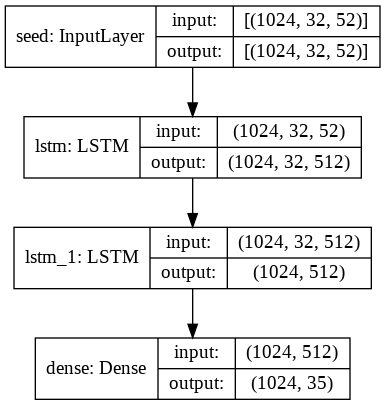

In [0]:
tf.keras.backend.clear_session()
model = lstm_model(seq_len=SEQ_LEN, stateful=False, num_units=NUM_UNITS, n_features=NUM_FEATURES,
                             num_classes=NUM_CLASSES, batch_size=BATCH_SIZE)
#model = conv1D_model(seq_len=SEQ_LEN)
plot_model(model, show_shapes=True, to_file='{0}_architecture.png'.format(NAME))

In [0]:
NUM_EPOCHS = 20
# Create the indices and labels for the training dataset
indices, labels = valid_indices(np_train, seq_len=SEQ_LEN, include_list=INCLUDE, undersample=True)
train_steps = int(np.floor(len(indices)/BATCH_SIZE)) # Number of steps in the dataset

# Save the training indices to file 
with open('/content/train_indices.npy', 'wb') as f:
  np.save(f, indices)

with open("train_labels.pkl", 'wb') as f:
  pickle.dump(labels,f)

# Create the indices and labels for the testing dataset
indices, labels = valid_indices(np_test, seq_len=SEQ_LEN, include_list=INCLUDE, undersample=True)
test_steps = int(np.floor(len(indices)/BATCH_SIZE)) # Number of steps in the dataset

# Save the testing indices to file
with open('/content/test_indices.npy', 'wb') as f:
  np.save(f, indices)

with open("test_labels.pkl", 'wb') as f:
  pickle.dump(labels,f)


tf.keras.backend.clear_session() # Clear the session
ds, idxs = input_fn(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, 
                                                     num_classes=NUM_CLASSES, start=START, num_features=NUM_FEATURES,
                                                    dtype='train', shuffle=True)

ds_test, _ = input_fn(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, 
                                                     num_classes=NUM_CLASSES, start=START, num_features=NUM_FEATURES,
                                                    dtype='test', shuffle=False)
# Setting up the TPU Environment
resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

# Creating and compiling the model
with strategy.scope():
  training_model = lstm_model(seq_len=SEQ_LEN, stateful=False, num_units=NUM_UNITS, n_features=NUM_FEATURES,
                             num_classes=NUM_CLASSES, batch_size=BATCH_SIZE)
  # training_model = conv1D_model(seq_len=SEQ_LEN, n_features=NUM_FEATURES, num_classes=NUM_CLASSES)
  adams = tf.train.AdamOptimizer(learning_rate=LR)
  sgd = tf.keras.optimizers.SGD(momentum=0.006)
  training_model.compile(
  optimizer=adams,
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']) # Compile with adam optimizer

# Checkpoint to save the model every two epochs
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/data/result/weights.{epoch:02d}-{categorical_accuracy:.2f}.hdf5", 
                                                monitor='categorical_accuracy', verbose=0, save_best_only=False, 
                                                save_weights_only=False, mode='auto', period=2)
# Stopper to stop training if loss does not improve three times in a row
stopper = tf.keras.callbacks.EarlyStopping(patience=3,monitor='loss')

# Fitting the model
history = training_model.fit(ds, 
                             epochs=NUM_EPOCHS, steps_per_epoch=train_steps,
                            callbacks=[checkpoint], 
                            validation_data=ds_test if VAL else None, 
                             validation_steps=test_steps if VAL else None)

# Saving to local and to google drive
training_model.save('/content/lstm.hdf5', overwrite=True)
training_model.save('/content/gdrive/My Drive/data/result/{0}.hdf5'.format(NAME), overwrite=True)
training_model.save_weights('/content/gdrive/My Drive/data/result/weights_{0}.h5', overwrite=True)

# Saving the training history
with open('/content/gdrive/My Drive/data/result/trainHistoryDict.pkl', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)


INFO:tensorflow:Initializing the TPU system.
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.66.108.106:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 12377113003391828477)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3348080788080880985)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3435647507285992135)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 15758976433358525582)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 1

### Dataset Size Impact


The below scripts will test and plot the impact of the dataset size

In [0]:
## Run this code to test the impact of the dataset size 
# fracs = [0.2,0.5, 0.7, 1]
# VAL = True
# for val in fracs:
#   np_train = np_train_og[0:int(len(np_train_og)*val)]
#   np_test = np_test_og[0:int(len(np_test_og)*val)]

  
#   # Create the indices and labels for the training dataset
#   indices, labels = valid_indices(np_train, seq_len=SEQ_LEN, include_list=INCLUDE, undersample=True)
#   train_steps = int(np.floor(len(indices)/BATCH_SIZE)) # Number of steps in the dataset

#   print("Starting session with fraction = {0}, resulting in a dataset length of {1} and {2} samples per class after undersampling".
#         format(val, len(np_train), Counter(x for x in labels.values())[0]))
#   # Save the training indices to file 
#   with open('/content/train_indices.npy', 'wb') as f:
#     np.save(f, indices)

#   with open("train_labels.pkl", 'wb') as f:
#     pickle.dump(labels,f)

#   # Create the indices and labels for the testing dataset
#   indices, labels = valid_indices(np_test, seq_len=SEQ_LEN, include_list=INCLUDE, undersample=True)
#   test_steps = int(np.floor(len(indices)/BATCH_SIZE)) # Number of steps in the dataset

#   # Save the testing indices to file
#   with open('/content/test_indices.npy', 'wb') as f:
#     np.save(f, indices)

#   with open("test_labels.pkl", 'wb') as f:
#     pickle.dump(labels,f)


#   tf.keras.backend.clear_session() # Clear the session
#   ds, idxs = input_fn(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, num_epochs=int(NUM_EPOCHS/val), 
#                                                       num_classes=NUM_CLASSES, start=START, num_features=NUM_FEATURES,
#                                                       dtype='train', shuffle=True)
#   ds_test, _ = input_fn(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, num_epochs=int(NUM_EPOCHS/val), 
#                                                       num_classes=NUM_CLASSES, start=START, num_features=NUM_FEATURES,
#                                                       dtype='test', shuffle=True)
#   # Setting up the TPU Environment
#   resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
#   tf.contrib.distribute.initialize_tpu_system(resolver)
#   strategy = tf.contrib.distribute.TPUStrategy(resolver)

#   # Creating and compiling the model
#   with strategy.scope():
#     training_model = lstm_model(seq_len=SEQ_LEN, stateful=False, num_units=NUM_UNITS, n_features=NUM_FEATURES,
#                               num_classes=NUM_CLASSES, batch_size=BATCH_SIZE)
#     #adams = tf.train.AdamOptimizer(learning_rate=LR)
#     adams = tf.keras.optimizers.Adam(learning_rate=LR)
#     #sgd = tf.keras.optimizers.SGD(momentum=0.006)
#     training_model.compile(
#     optimizer=adams,
#     loss='categorical_crossentropy',
#     metrics=['categorical_accuracy']) # Compile with adam optimizer

#   # Checkpoint to save the model every two epochs
#   checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/data/result/weights.{epoch:02d}-{categorical_accuracy:.2f}.hdf5", 
#                                                   monitor='categorical_accuracy', verbose=0, save_best_only=False, 
#                                                   save_weights_only=False, mode='auto', period=2)
#   # Stopper to stop training if loss does not improve three times in a row
#   stopper = tf.keras.callbacks.EarlyStopping(patience=3,monitor='loss')

#   # Fitting the model
#   history = training_model.fit(ds, 
#                               epochs=int(NUM_EPOCHS/val), steps_per_epoch=train_steps,
#                               callbacks=[checkpoint], 
#                               validation_data= ds_test if VAL else None, 
#                               validation_steps=test_steps if VAL else None,
#                                verbose=2)

#   # Saving to local and to google drive
#   training_model.save('/content/lstm_frac{0}.hdf5'.format(val), overwrite=True)
#   training_model.save('/content/gdrive/My Drive/data/result/{0}frac{1}.hdf5'.format(NAME,val), overwrite=True)
#   training_model.save_weights('/content/gdrive/My Drive/data/result/weights_{0}.h5', overwrite=True)

#   # Saving the training history
#   with open('/content/gdrive/My Drive/data/result/trainHistoryDictFrac{0}.pkl'.format(val), 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

In [0]:
# def plot_history(hist, fracs=None):
#   %matplotlib inline
#   fig, ax = plt.subplots()
#   i = 0
#   colors = ['b', 'g', 'r', 'k']
#   ranges = [np.linspace(0,35,8), np.linspace(0,14,8), [0,1, 2, 4, 5, 6, 8, 10], np.linspace(0,7,8)]
#   ranges = [np.linspace(0,34,7,dtype=np.int32), np.linspace(0,13,7,dtype=np.int32), 
#             np.linspace(0,9,7,dtype=np.int32), np.linspace(0,6,7,dtype=np.int32)]
#   for history in hist:
#     plt.plot(np.linspace(1.614848/7,1.614848,7), [history['categorical_accuracy'][int(idx)] for idx in ranges[i]], '{0}-'.format(colors[i]), 
#              linewidth=3, markersize=10, label='Training (f={0})'.format(fracs[i]))
#     plt.plot(np.linspace(1.614848/7,1.614848,7), [history['val_categorical_accuracy'][int(idx)] for idx in ranges[i]], '{0}--'.format(colors[i]), 
#              linewidth=3, markersize=10, label='Testing (f={0})'.format(fracs[i]))
#     i = i + 1
#   fig.set_size_inches(15,10)
#   plt.legend(loc=0, borderaxespad=1)
#   plt.title('Training accuracy using different sizes of datasets', fontsize=20)
#   ax.set_xlabel('Number of samples seen (x1,000,000)', fontsize=20)
#   ax.set_ylabel('Categorical Accuracy', fontsize=20)
#   plt.yticks(fontsize=15)

#   plt.savefig('/content/accuracy_dataset_size.pdf')

#   fig, ax = plt.subplots()
#   i = 0
#   for history in hist:
#     plt.plot(np.linspace(1.614848/7,1.614848,7), [history['loss'][int(idx)] for idx in ranges[i]], '{0}-'.format(colors[i]), 
#              linewidth=3, markersize=10, label='Training (f={0})'.format(fracs[i]))
#     plt.plot(np.linspace(1.614848/7,1.614848,7), [history['val_loss'][int(idx)] for idx in ranges[i]], '{0}--'.format(colors[i]), 
#              linewidth=3, markersize=10, label='Testing (f={0})'.format(fracs[i]))
#     i = i + 1
#   fig.set_size_inches(15,10)
#   plt.legend(loc=0, borderaxespad=1)
#   plt.title('Training loss using different sizes of datasets', fontsize=20)
#   ax.set_xlabel('Number of samples seen (x1,000,000)', fontsize=20)
#   ax.set_ylabel('Loss', fontsize=20)
#   plt.yticks(fontsize=15)

#   plt.savefig('/content/loss_dataset_size.pdf')

In [0]:
# fracs = [0.2,0.5, 0.7, 1]
# test = []
# for frac in fracs:
#   with open("/content/gdrive/My Drive/data/result/trainHistoryDictFrac{0}.pkl".format(frac), 'rb') as rf:
#     hist = pickle.load(rf)
#     # for key, val in hist.items():
#     #   val.insert(0,0)
#     #   hist[key] = val
#     test.append(hist)
# plot_history(test, fracs)

In [0]:
# from scipy.stats import linregress
# from scipy.optimize import curve_fit
# vals = [0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.]
# def func(x, a, b, c):
#   return a * np.exp(-b * x) + c
# max_acc = []
# min_loss = []
# max_acc_val = []
# min_loss_val = []
# for hist in test:
#   max_acc.append((hist['categorical_accuracy'][-1]))
#   max_acc_val.append((hist['val_categorical_accuracy'][-1]))
#   min_loss.append((hist['loss'][-1]))
#   min_loss_val.append((hist['val_loss'][-1]))

# fig, ax = plt.subplots()
# slope, intercept, r_value, p_value, std_err = linregress(fracs, max_acc_val)
# popt, pcov = curve_fit(func, fracs, max_acc_val)
# print("p_value: ", p_value)
# plt.plot(fracs,max_acc, '-*',label='Training Accuracy', linewidth=3, markersize=15)
# plt.plot(fracs,max_acc_val,'r--o',label='Testing Accuracy', linewidth=3, markersize=15)
# #plt.plot(fracs, intercept + np.array(fracs)*slope, 'r', label='Fitted Line')
# plt.plot(vals, func(np.array(vals), *popt), 'k', linewidth=3,
#          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
# plt.annotate('Slope = {0:.3g}\np_value = {1:.3g}\nr_value = {2:.3g}'.format(slope, p_value, r_value), xy=(fracs[-1]-0.2, max_acc_val[-1]-0.1), 
#              xytext=(fracs[-1]-0.2, max_acc_val[-1]-0.1), fontsize=15)

# fig.set_size_inches(15,10)
# plt.legend(loc=0, borderaxespad=1)
# plt.title('Accuracy for different dataset sizes', fontsize=20)
# ax.set_xlabel('Fraction of the full dataset', fontsize=20)
# ax.set_ylabel('Categorical Accuracy', fontsize=20)
# plt.yticks(fontsize=15)
# plt.xticks(fracs)

# plt.savefig('/content/acc_trend.pdf')

# fig, ax = plt.subplots()
# slope, intercept, r_value, p_value, std_err = linregress(fracs, min_loss_val)
# print("p_value: ", p_value)
# plt.plot(fracs,min_loss, '-*',label='Training Loss', linewidth=3, markersize=15)
# plt.plot(fracs,min_loss_val,'r--o',label='Testing Loss', linewidth=3, markersize=15)
# plt.plot(fracs, intercept + np.array(fracs)*slope, 'r', label='Fitted Line')
# plt.annotate('Slope = {0:.3g}\np_value = {1:.3g}\nr_value = {2:.3g}'.format(slope, p_value, r_value), xy=(fracs[-1]-0.2, min_loss_val[-1]-0.2), 
#              xytext=(fracs[-1]-0.2, min_loss_val[-1]-0.2), fontsize=15)

# fig.set_size_inches(15,10)
# plt.legend(loc=0, borderaxespad=1)
# plt.title('Loss for different dataset sizes', fontsize=20)
# ax.set_xlabel('Fraction of the full dataset', fontsize=20)
# ax.set_ylabel('Loss', fontsize=20)
# plt.yticks(fontsize=15)
# plt.xticks(fracs)

# plt.savefig('/content/loss_trend.pdf')

## Results, Plotting and Testing

### Plotting the training history over epochs

KeyError: ignored

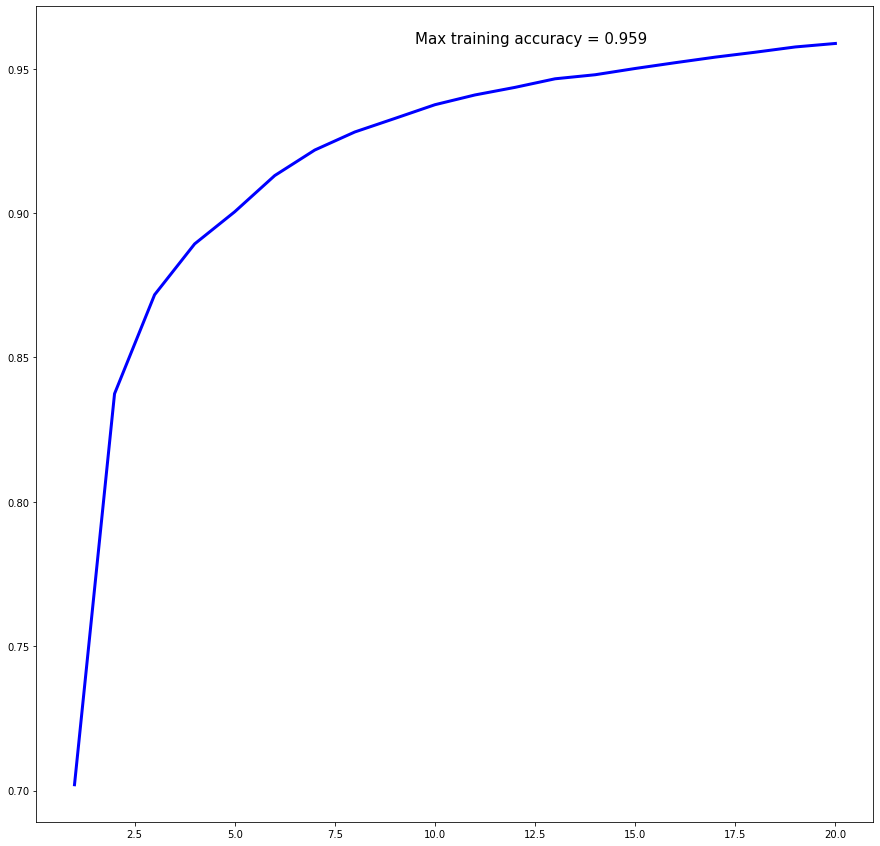

In [0]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(np.arange(1,NUM_EPOCHS+1),history.history['categorical_accuracy'],'b-', linewidth=3, markersize=10, label='Training')
#plt.plot(np.arange(1,NUM_EPOCHS+1),history.history['val_categorical_accuracy'],'b--', linewidth=3, markersize=10, label='Testing')

fig.set_size_inches(15,15)
ymax = max(history.history['categorical_accuracy'])
xmax = history.history['categorical_accuracy'].index(ymax)
plt.annotate('Max training accuracy = {0:.3g}'.format(ymax), xy=(xmax, ymax), 
             xytext=(xmax/2, ymax), fontsize=15)

ymax = max(history.history['val_categorical_accuracy'])
xmax = history.history['val_categorical_accuracy'].index(ymax)
plt.annotate('Max validation accuracy = {0:.3g}'.format(ymax), xy=(xmax, ymax), 
             xytext=(xmax/2, ymax), fontsize=15)

plt.legend(loc=0, borderaxespad=1)
plt.title('Training accuracy over epochs', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Categorical Accuracy', fontsize=20)
plt.xticks(np.arange(1,NUM_EPOCHS+1), fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('{0}_accuracy.pdf'.format(NAME))

fig, ax = plt.subplots()
plt.plot(np.arange(1,NUM_EPOCHS+1),history.history['loss'],'--', linewidth=3, markersize=10, label='Training')
#plt.plot(np.arange(1,NUM_EPOCHS+1),history.history['val_loss'],'--', linewidth=3, markersize=10, label='Testing')

fig.set_size_inches(15,15)
ymin = min(history.history['loss'])
xmin = history.history['loss'].index(ymin)
plt.annotate('Best training loss = {0:.3g}'.format(ymin), xy=(xmin, ymin), 
             xytext=(xmin/2, ymin), fontsize=15)

# fig.set_size_inches(15,15)
# ymin = min(history.history['val_loss'])
# xmin = history.history['val_loss'].index(ymin)
# plt.annotate('Best training loss = {0:.3g}'.format(ymin), xy=(xmin, ymin), 
#              xytext=(xmin/2, ymin), fontsize=15)

plt.legend(loc=0, borderaxespad=1)
plt.title('Training loss for different sequence lengths', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
plt.xticks(np.arange(1,NUM_EPOCHS+1), fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('{0}_loss.pdf'.format(NAME))

### Predictions and plotting

In [0]:
BATCH_SIZE = 1024
file_name = '/content/gdrive/My Drive/data/result/{0}.hdf5'.format(NAME)
#file_name = '/content/gdrive/My Drive/data/result/lstm_ALL.hdf5'
#file_name = '/content/all.hdf5'
# # TRAINING SET
# indices, labels = valid_indices(np_train, seq_len=SEQ_LEN, include_list=INCLUDE, undersample=True)
# train_steps = int(np.floor(len(indices)/BATCH_SIZE)) # Number of steps in the dataset

# # Save the testing indices to file
# with open('/content/train_indices.npy', 'wb') as f:
#   np.save(f, indices)

# with open("train_labels.pkl", 'wb') as f:
#   pickle.dump(labels,f)

# ds_train, _ = input_fn(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, num_epochs=1, 
#                                                      num_classes=NUM_CLASSES, start=START, num_features=NUM_FEATURES,
#                                                     dtype='train', shuffle=False)

# prediction_model = lstm_model(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, stateful=False, 
#                               n_features=NUM_FEATURES, num_classes=NUM_CLASSES, 
#                               num_units=NUM_UNITS)
# prediction_model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR), loss='categorical_crossentropy', 
#                          metrics=['categorical_accuracy']) # Compile with adam optimizer
# prediction_model.load_weights(file_name)
# prediction_model.reset_states()
# prediction_model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR), loss='categorical_crossentropy', 
#                          metrics=['categorical_accuracy'])
# print("Starting predictions on training set...")
# predictions_train = prediction_model.predict(ds_train, steps=train_steps, verbose=1)

## TEST SET
indices, labels = valid_indices(np_test, seq_len=SEQ_LEN, include_list=INCLUDE, undersample=False)
indices = indices[0:92940]
test_steps = int(np.floor(len(indices)/BATCH_SIZE)) # Number of steps in the dataset

# Save the testing indices to file
with open('/content/test_indices.npy', 'wb') as f:
  np.save(f, indices)

with open("test_labels.pkl", 'wb') as f:
  pickle.dump(labels,f)

ds_test, _ = input_fn(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, num_epochs=1, 
                                                     num_classes=NUM_CLASSES, start=START, num_features=NUM_FEATURES,
                                                    dtype='test', shuffle=False)

prediction_model = lstm_model(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, stateful=False, n_features=NUM_FEATURES, num_classes=NUM_CLASSES, num_units=NUM_UNITS)
prediction_model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR), loss='categorical_crossentropy', 
                         metrics=['categorical_accuracy']) # Compile with adam optimizer
                         
prediction_model.load_weights(file_name)
prediction_model.reset_states()
plot_model(prediction_model, show_shapes=True, to_file='{0}_architecture.png'.format(NAME))
print("Starting predictions...")
predictions_test = prediction_model.predict(ds_test, steps=test_steps, verbose=1)




Starting predictions...
90/90 [==============================] - 49s 545ms/step


### Confusion Matrix

The below function creates a confusion matrix

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, 
                         annotate=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [classes[x] for x in unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fig.tight_layout()
    
    # Lines and size
    for pos in np.arange(0.5, len(classes)+0.5):
      ax.axhline(pos, linestyle='--')
      ax.axvline(pos, linestyle='--')
    fig.set_size_inches(15,15)
    
    if annotate:
      # Loop over data dimensions and create text annotations.
      fmt = '.2f' if normalize else 'd'
      thresh = cm.max() / 2.
      for i in range(cm.shape[0]):
          for j in range(cm.shape[1]):
              ax.text(j, i, format(cm[i, j], fmt),
                      ha="center", va="center",
                      color="white" if cm[i, j] > thresh else "black",
                     size=7)
    fig.tight_layout()
    return ax

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix


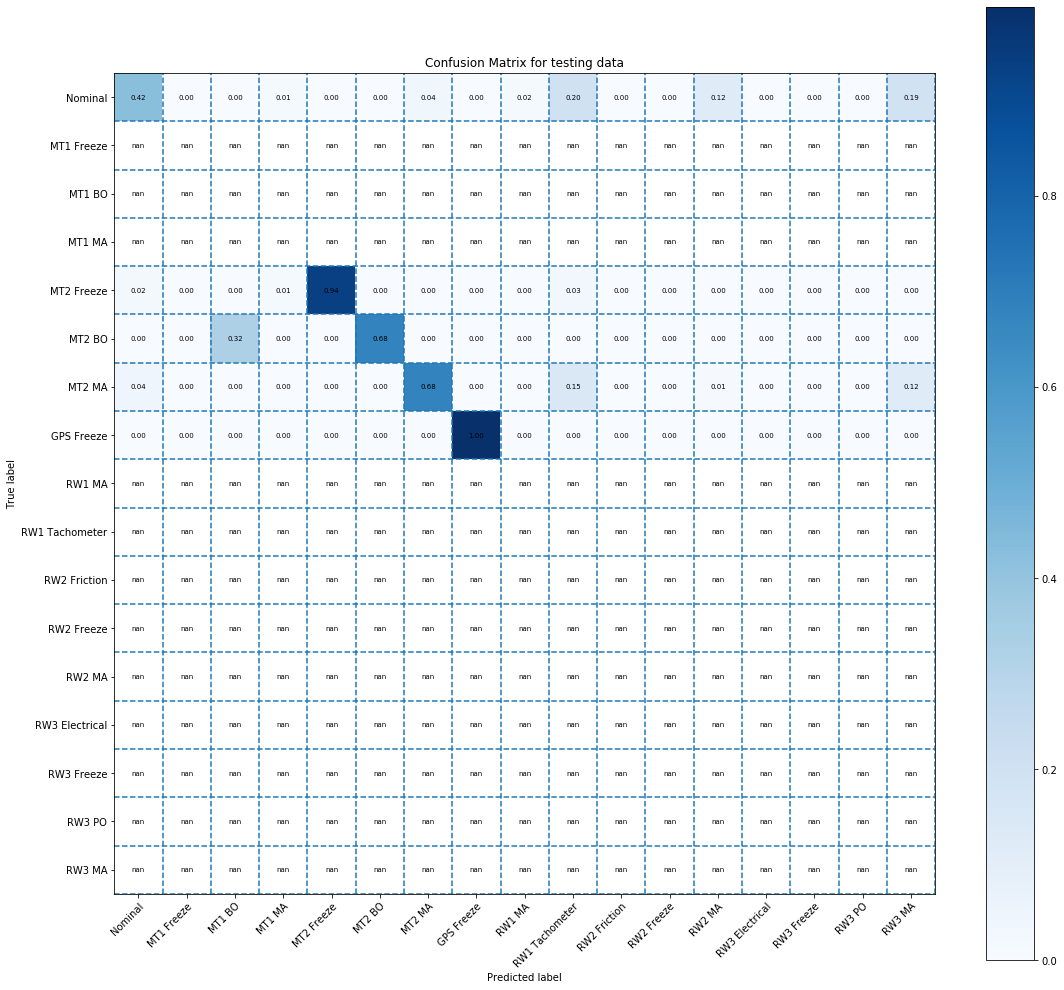

In [0]:
fault_dict = {0: 'Nominal', 1: 'ST1 Freeze', 2: 'ST1 BO', 3: 'ST1 MA',
             4: 'ST2 Freeze', 5: 'ST2 BO', 6: 'ST2 MA',
             7: 'MT1 Freeze', 8: 'MT1 BO', 9: 'MT1 MA',
             10: 'MT2 Freeze', 11: 'MT2 BO', 12: 'MT2 MA',
             13: 'GPS Freeze', 14: 'GPS BO',
             15: 'RW1 Friction', 16: 'RW1 Electrical', 17: 'RW1 Freeze',  18: 'RW1 PO',
             19: 'RW1 MA', 20: 'RW1 Tachometer',
             21: 'RW2 Friction', 22: 'RW2 Electrical', 23: 'RW2 Freeze', 24: 'RW2 PO',
             25: 'RW2 MA', 26: 'RW2 Tachometer',
             27: 'RW3 Friction', 28: 'RW3 Electrical', 29: 'RW3 Freeze',  30: 'RW3 PO',
             31: 'RW3 MA', 32: 'RW3 Tachometer',
             33: 'ST1&2 Freeze', 34: 'ST1&2 BO'}
# # ## TRAINING SET
# with open('/content/train_labels.pkl', 'rb') as f:
#   labels = pickle.load(f)

# CLASSES = [x for x in fault_dict.values()]
# y_true = [x for x in labels.values()]
# y_pred = np.argmax(predictions_train, axis=1)
# true_class = [CLASSES[x] for x in y_true]
# pred_class = [CLASSES[x] for x in y_pred]
# plot_confusion_matrix(y_true[0:len(y_pred)], 
#                       y_pred, 
#                       classes = CLASSES, 
#                       normalize=True, 
#                       title="Confusion Matrix for training data")

# plt.savefig('{0}_confusion_train.pdf'.format(NAME))

## TESTING SET
with open('/content/test_labels.pkl', 'rb') as f:
  labels = pickle.load(f)

CLASSES = [x for x in fault_dict.values()]
y_true = [int(x) for x in labels.values()]
y_pred = np.argmax(predictions_test, axis=1)
true_class = [CLASSES[x] for x in y_true]
pred_class = [CLASSES[x] for x in y_pred]

plot_confusion_matrix(y_true[0:len(y_pred)], 
                      y_pred, 
                      classes = CLASSES, 
                      normalize=True, 
                      title="Confusion Matrix for testing data")

plt.savefig('{0}_confusion_test.pdf'.format(NAME))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


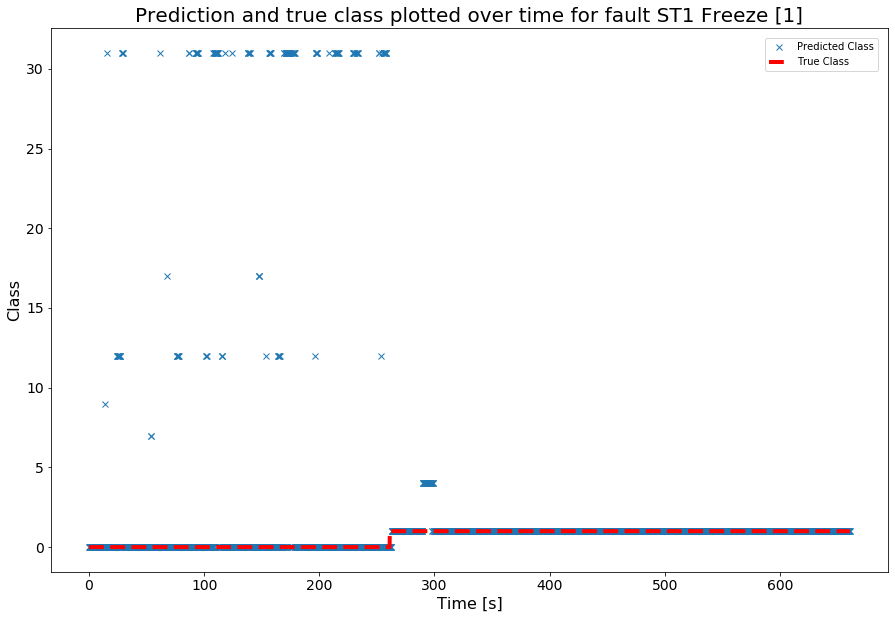

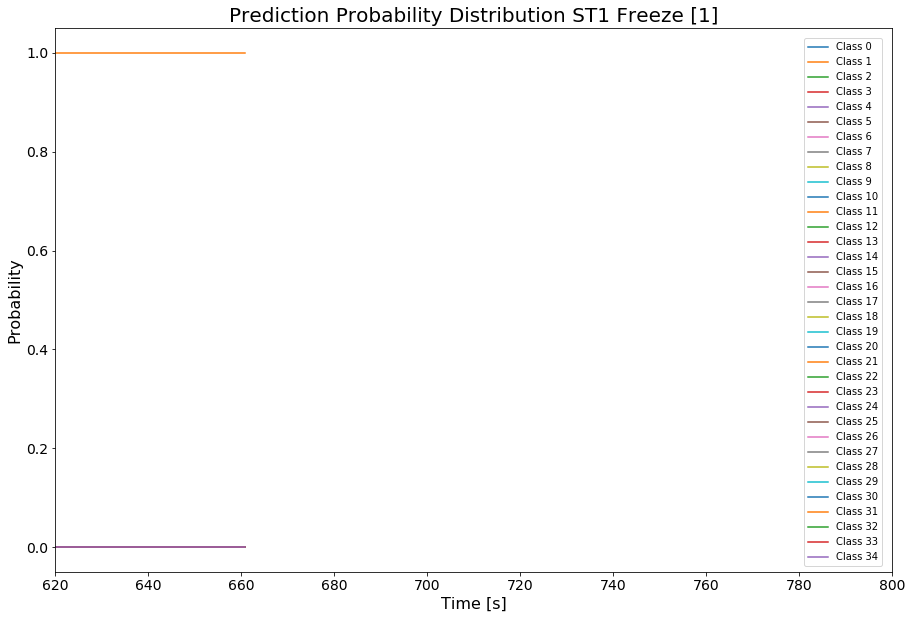

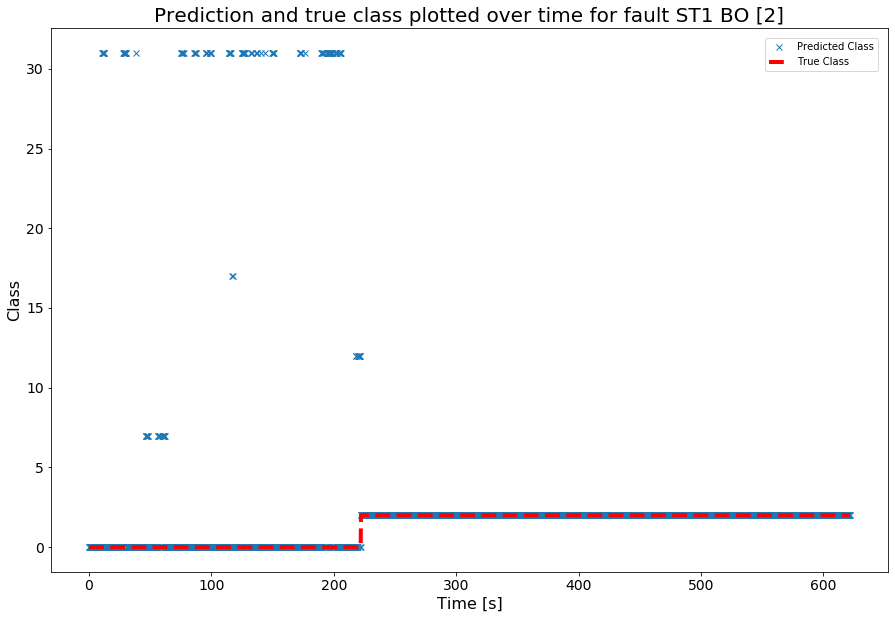

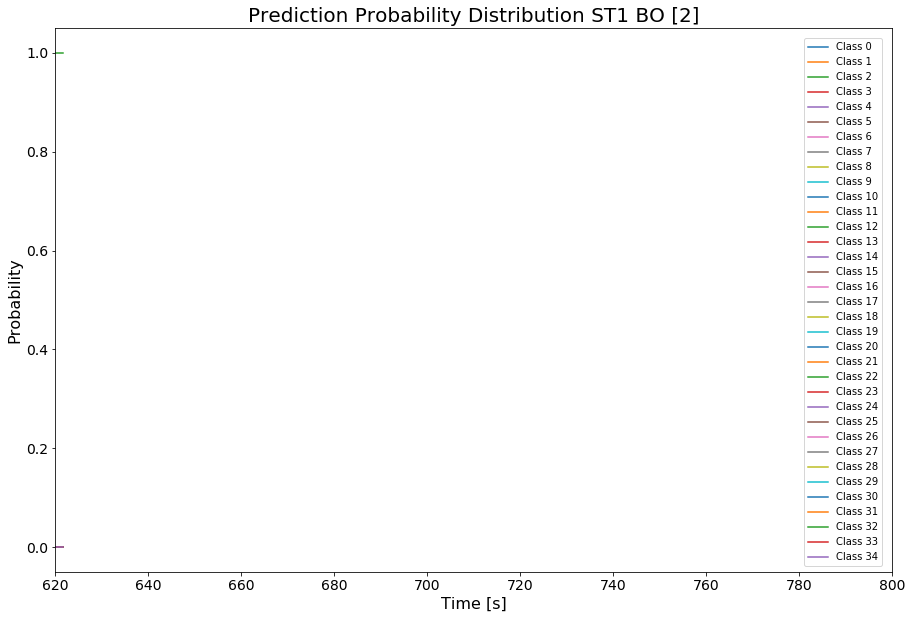

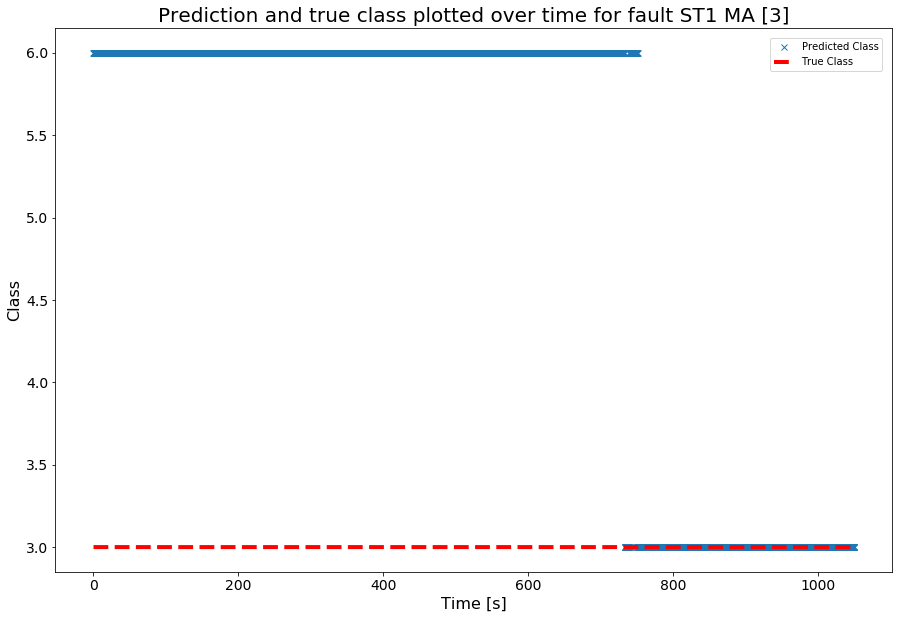

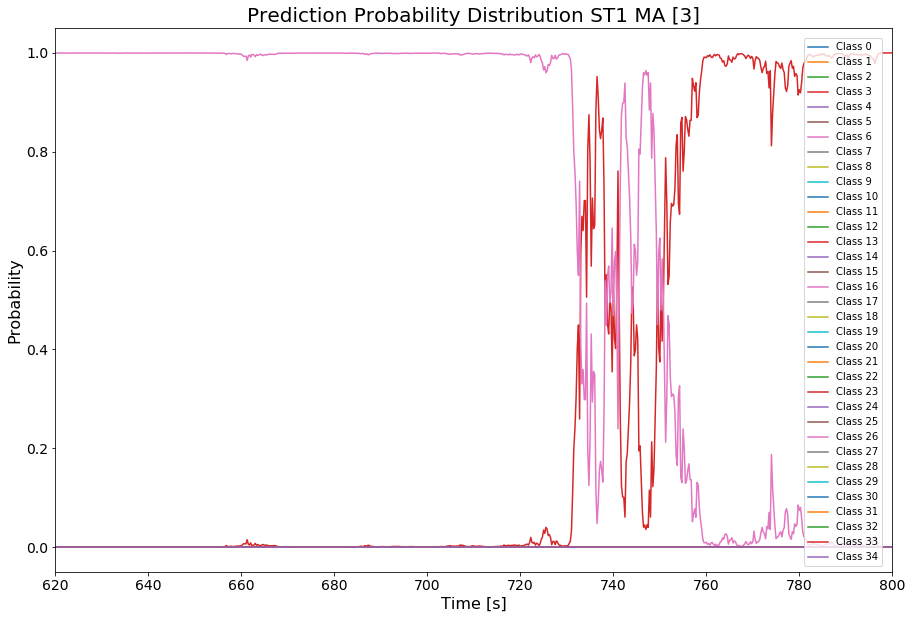

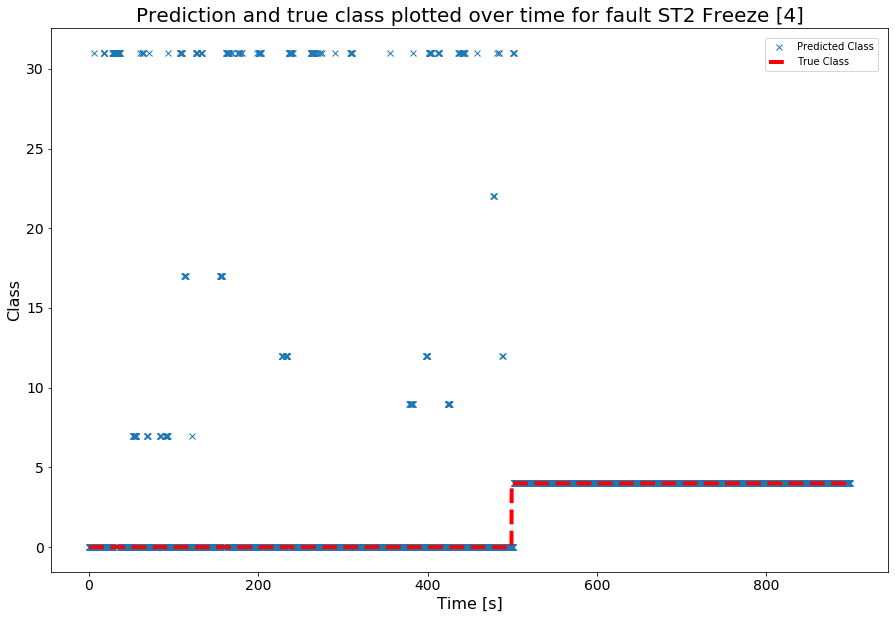

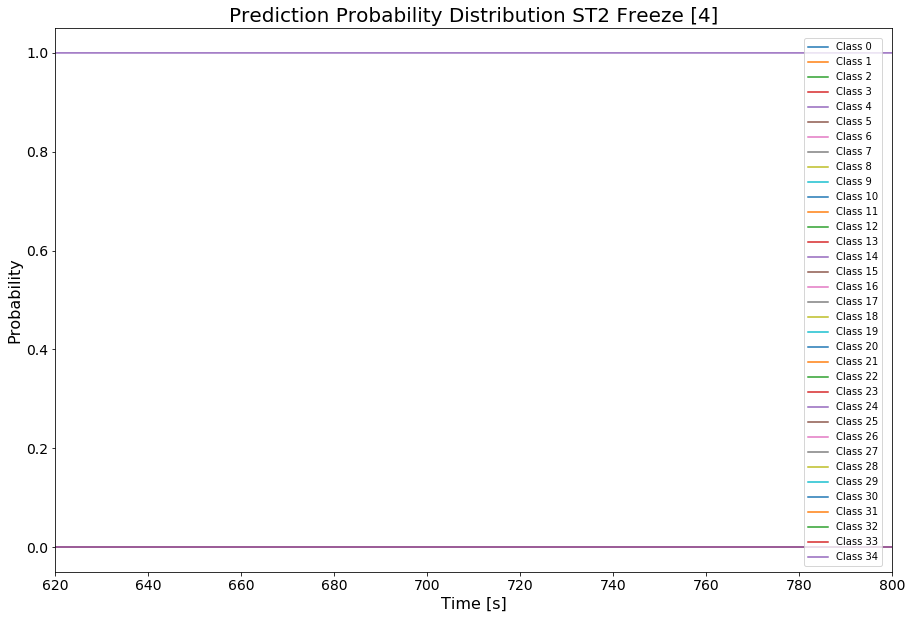

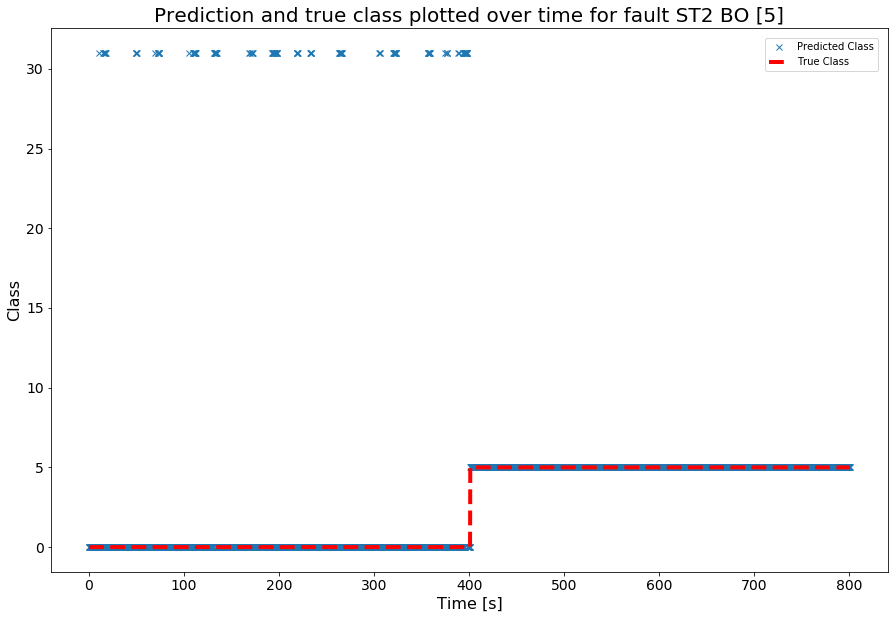

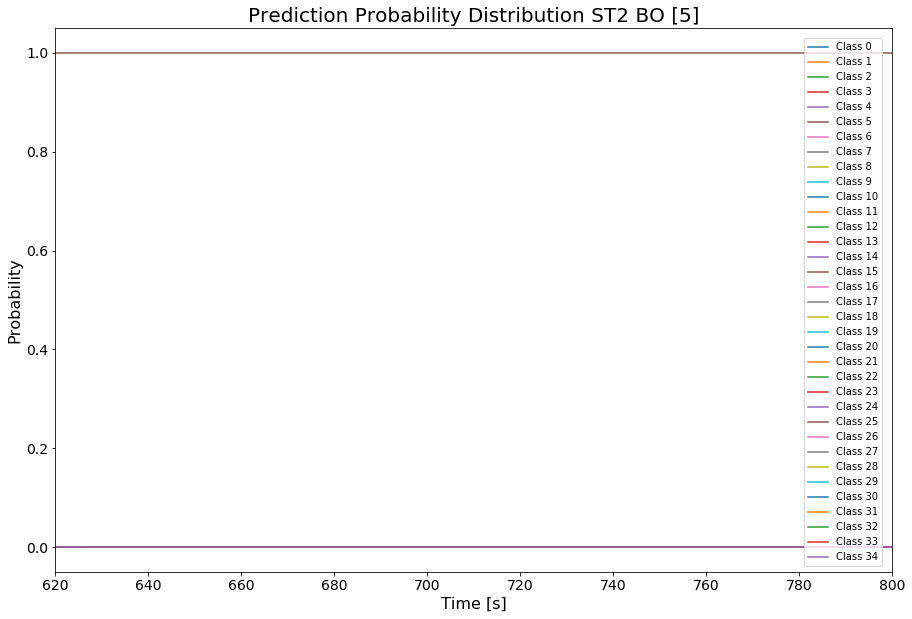

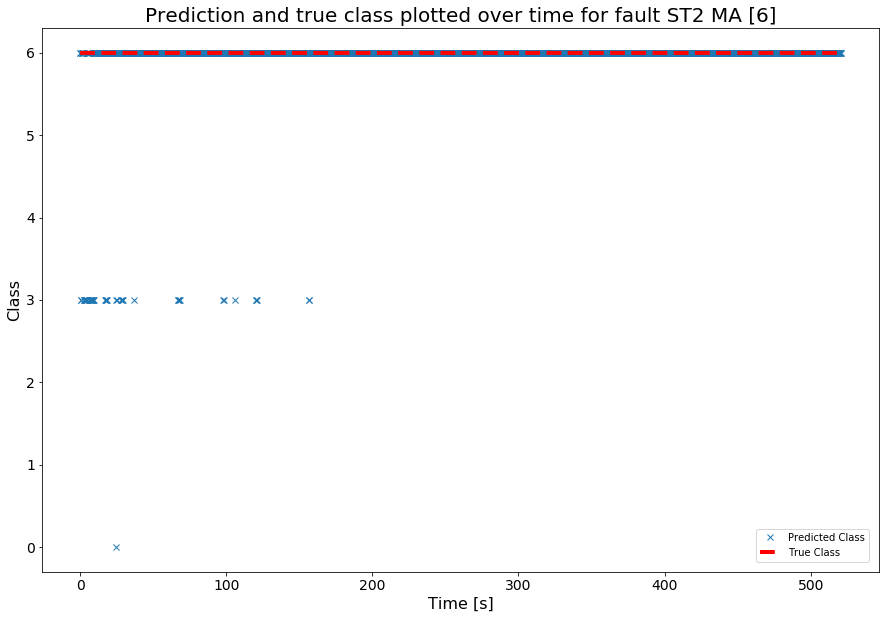

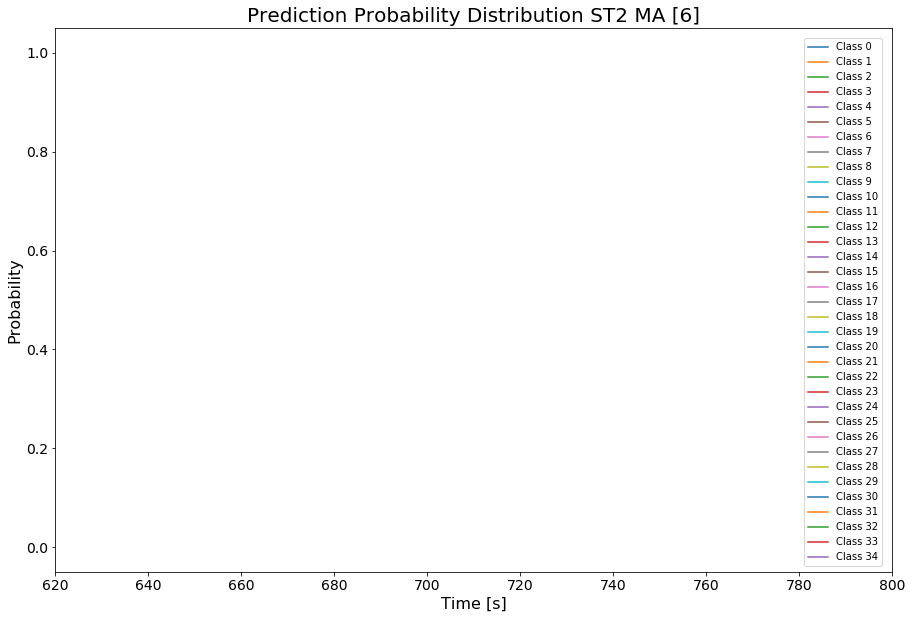

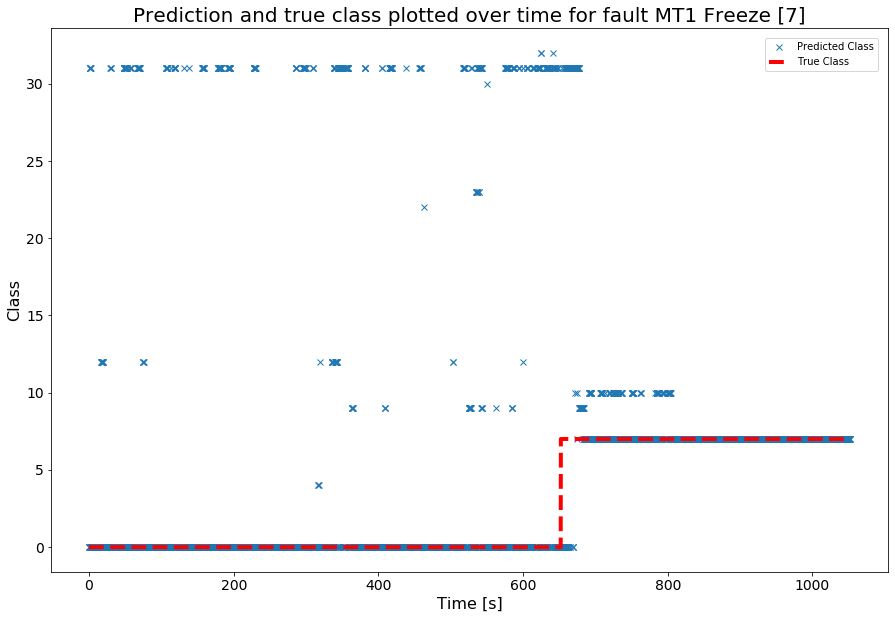

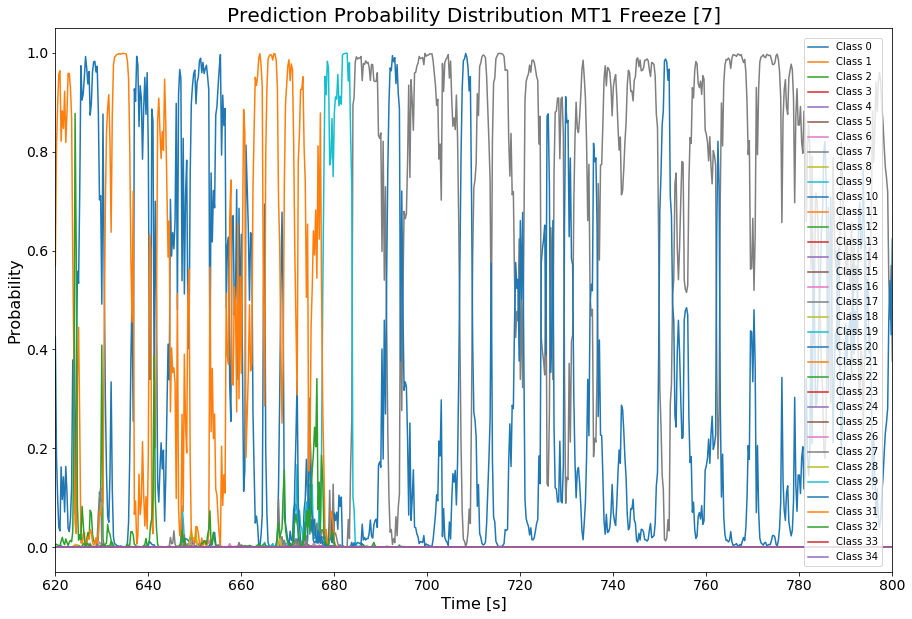

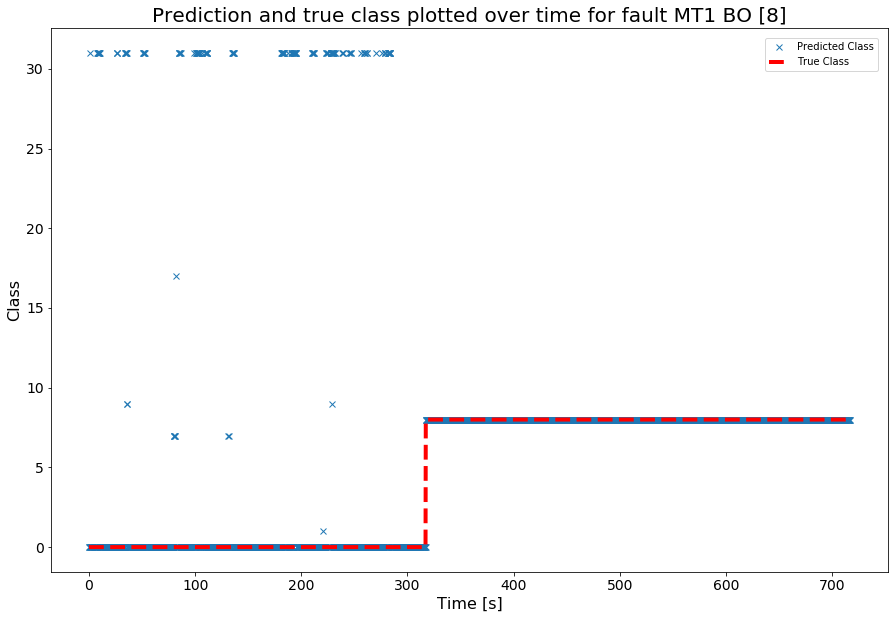

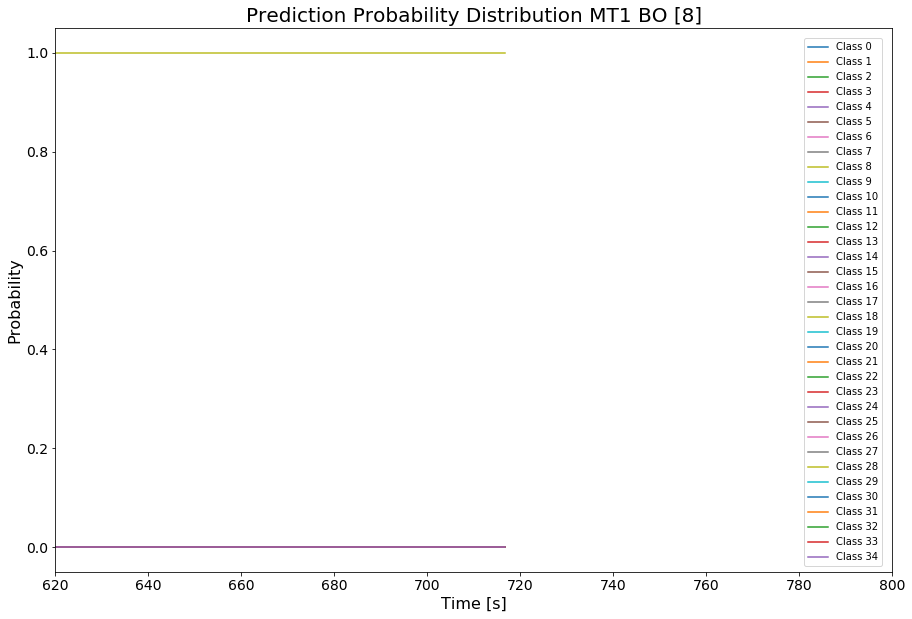

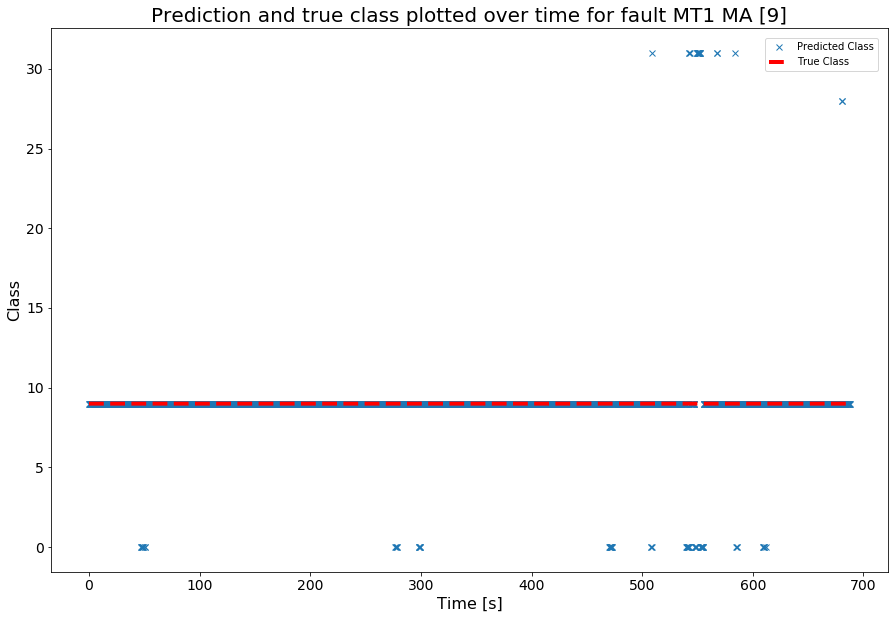

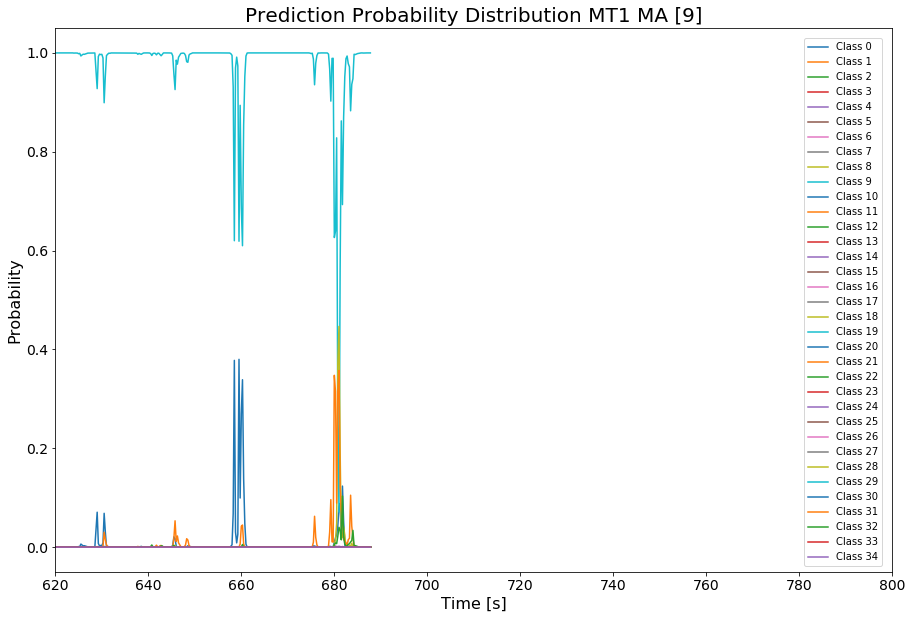

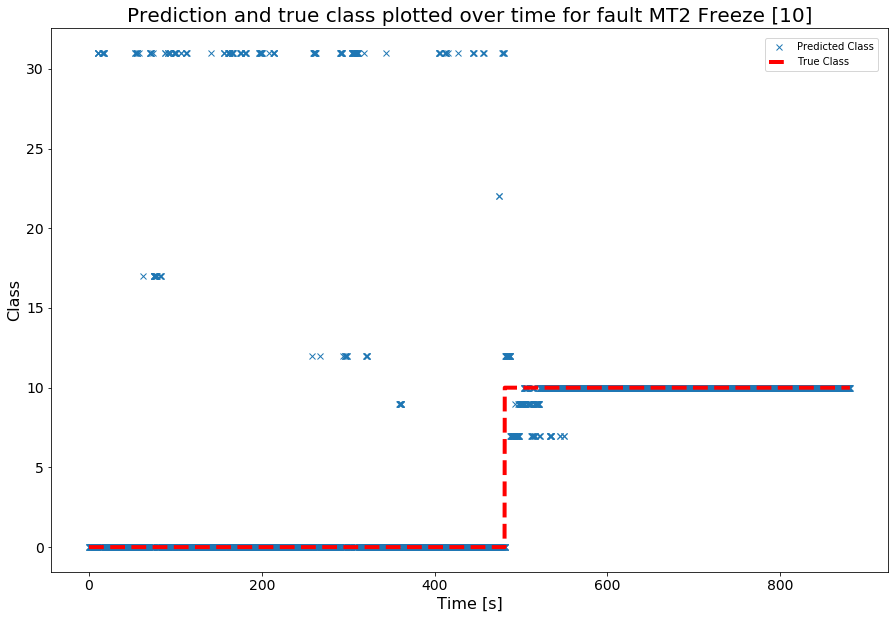

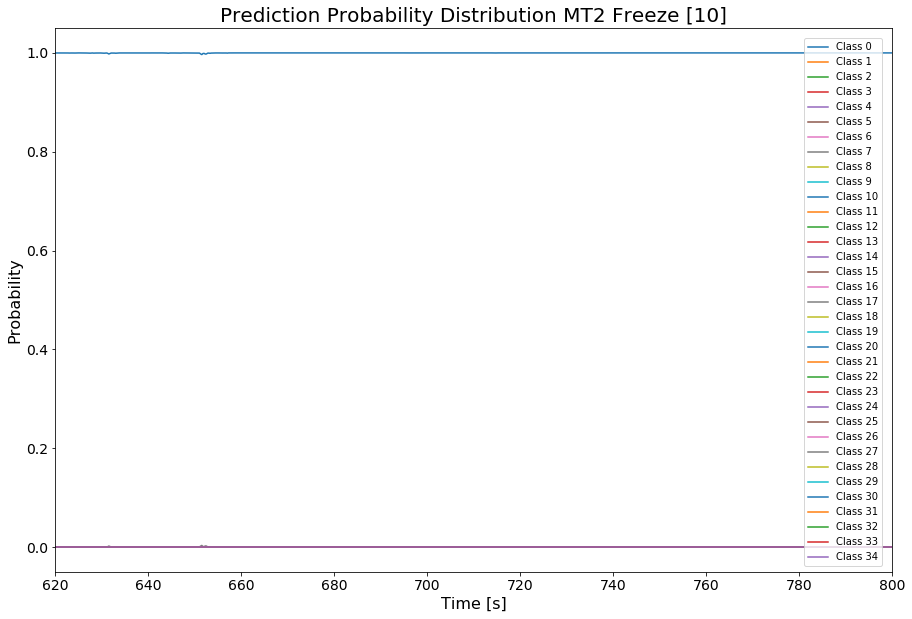

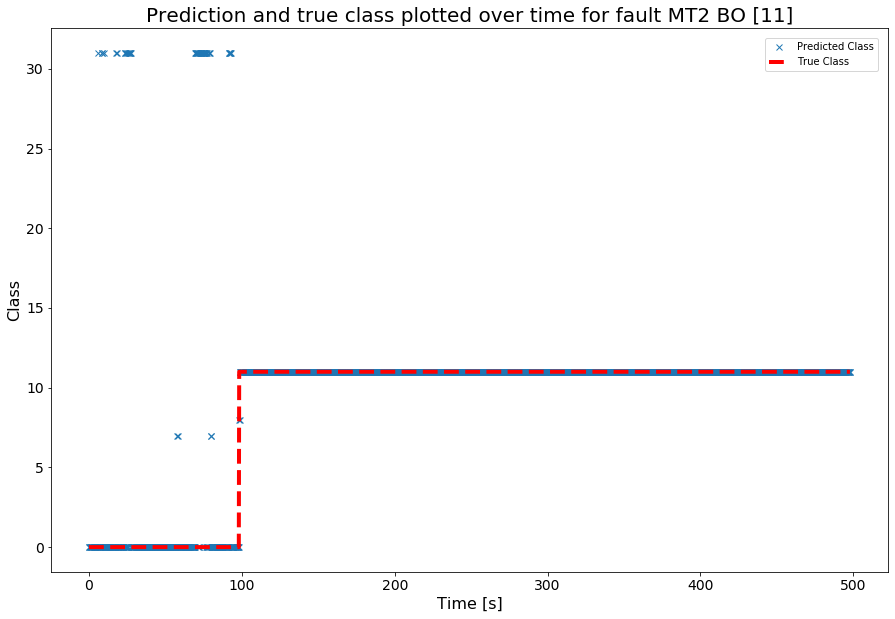

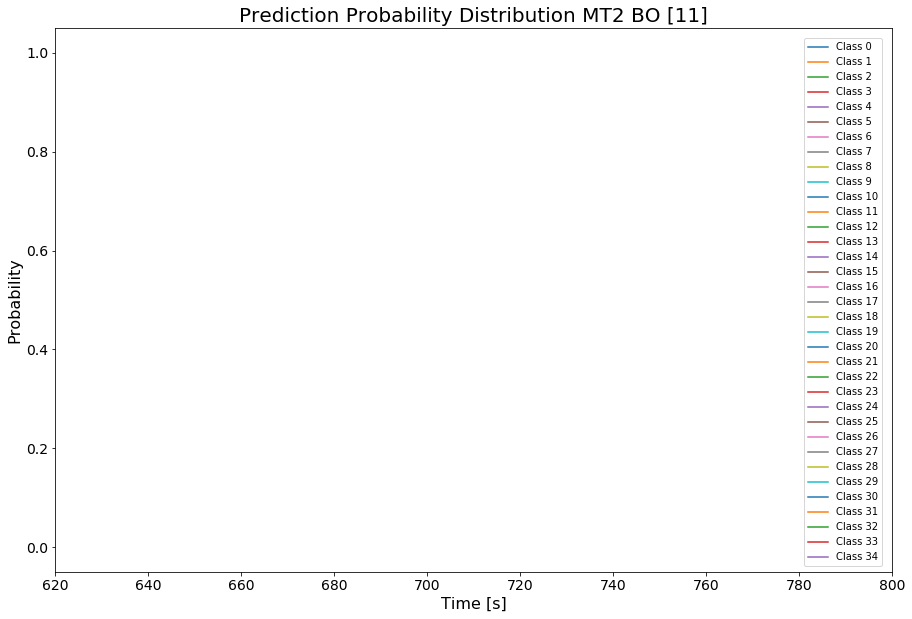

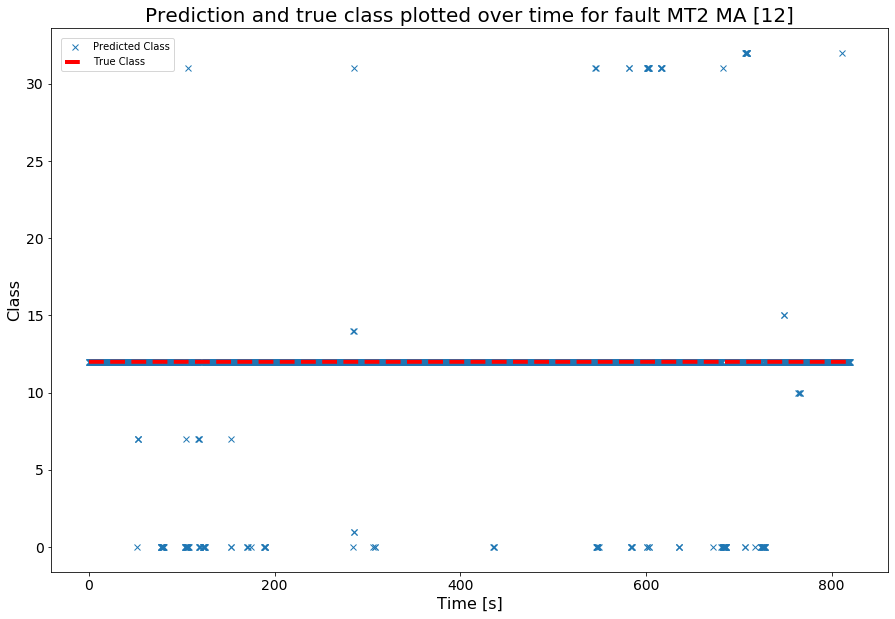

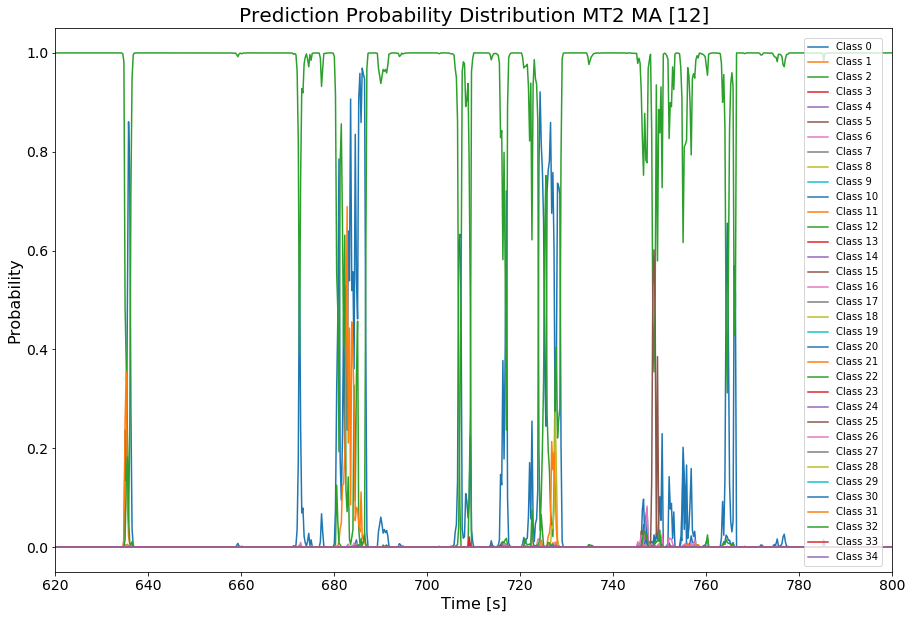

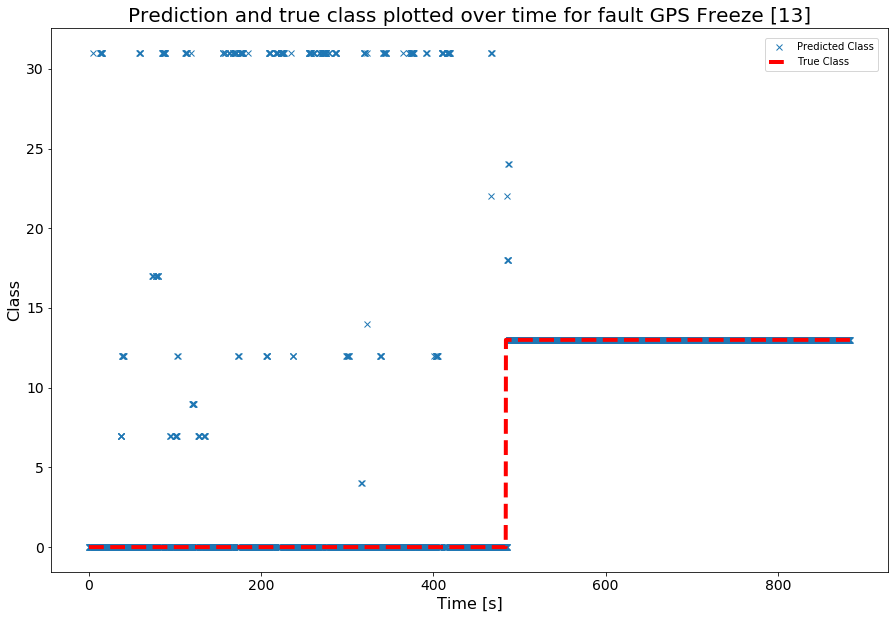

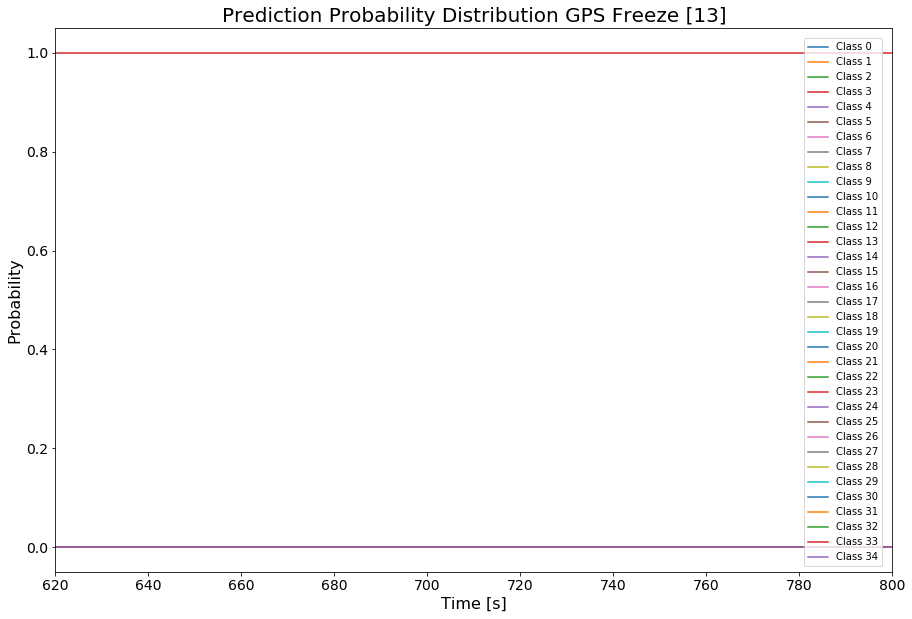

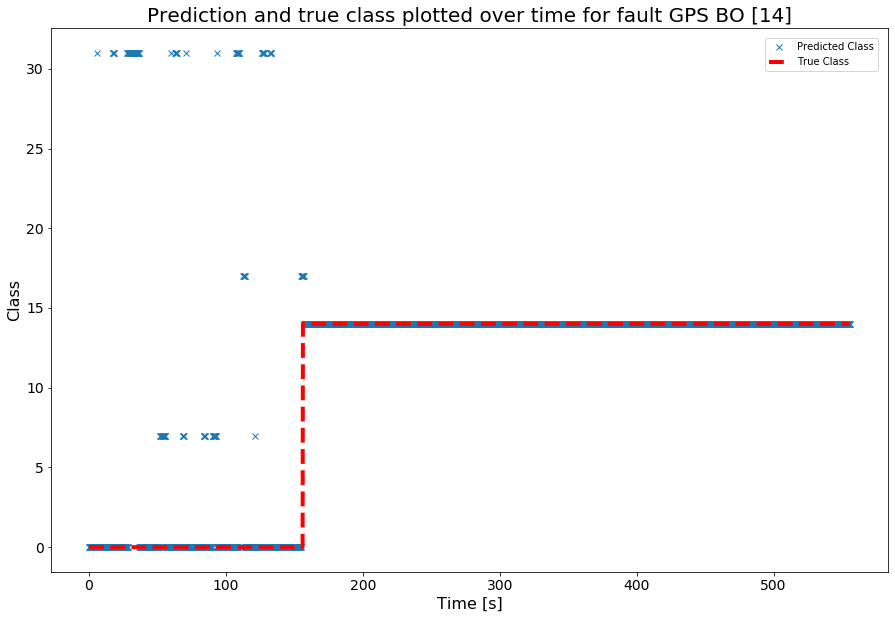

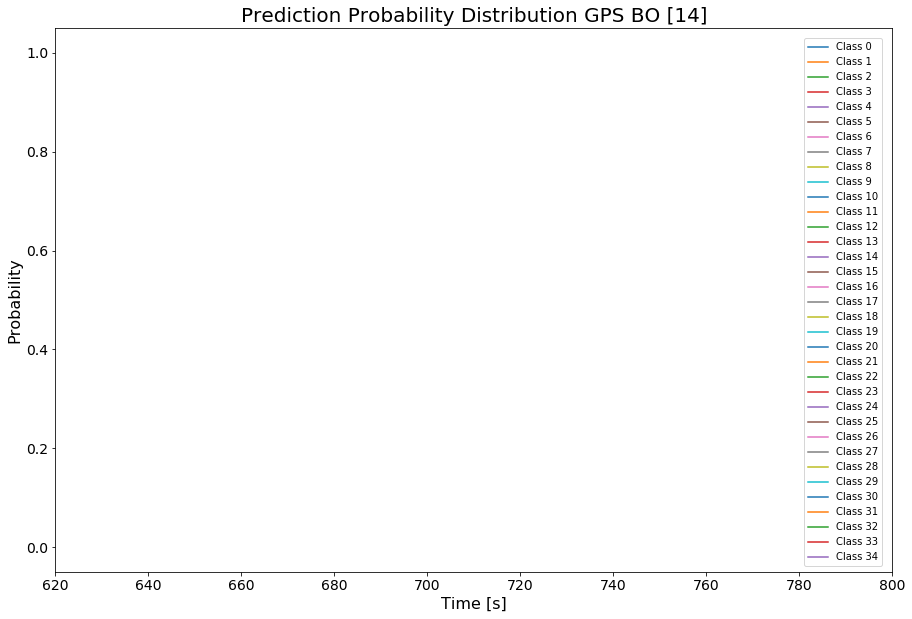

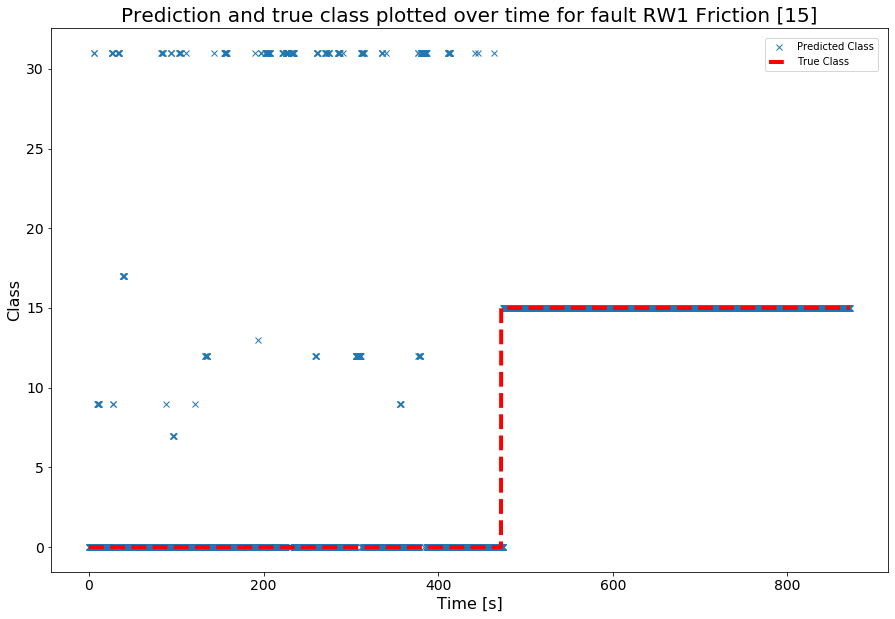

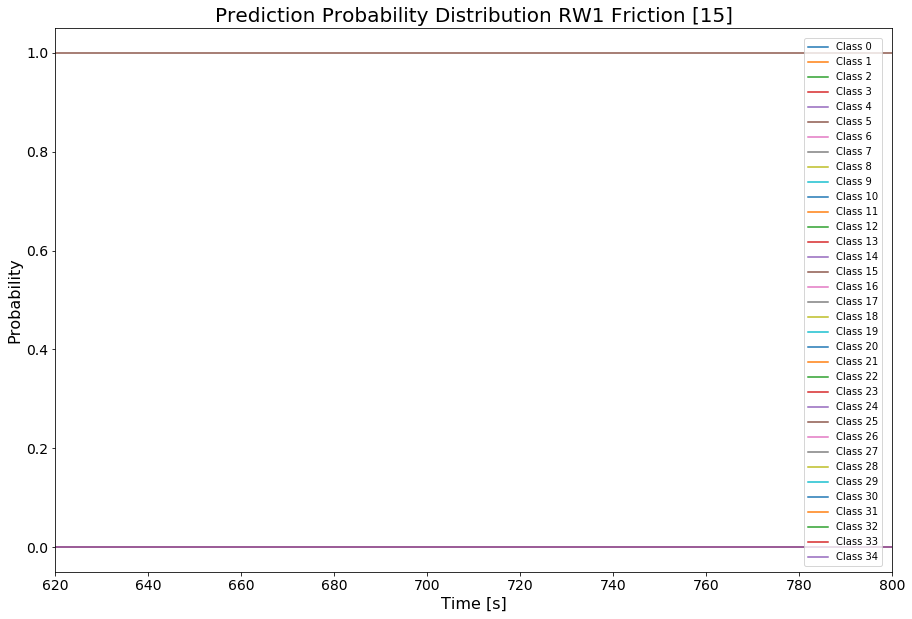

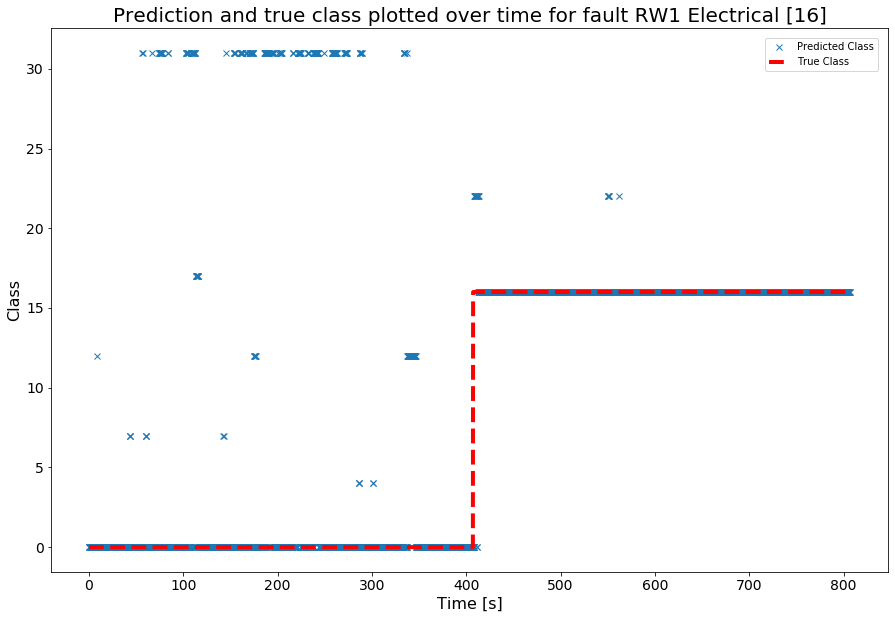

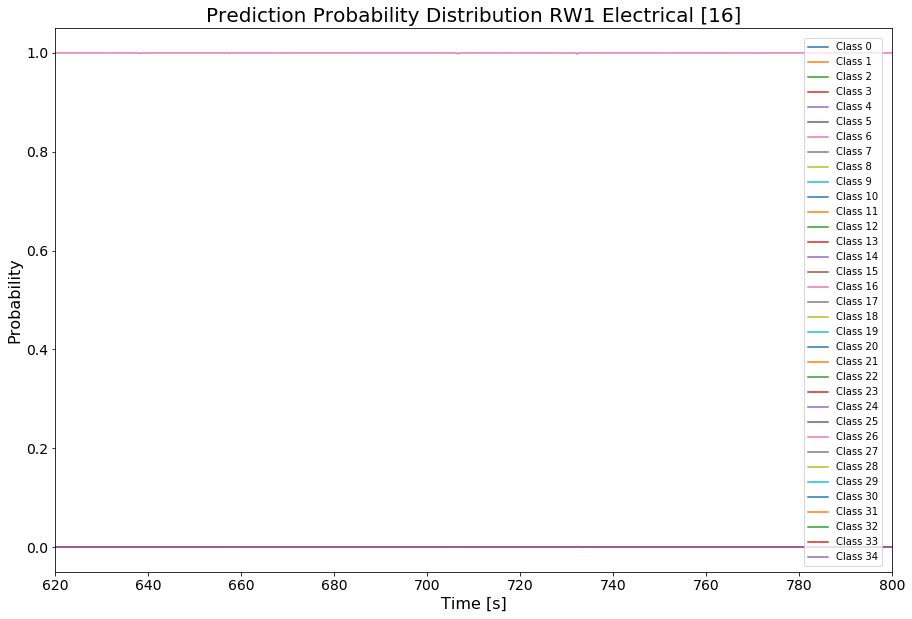

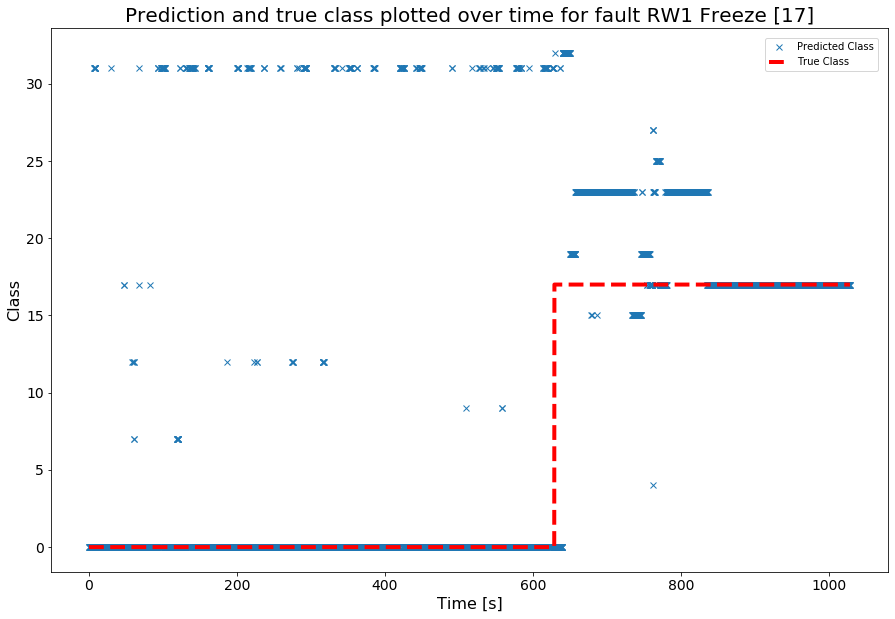

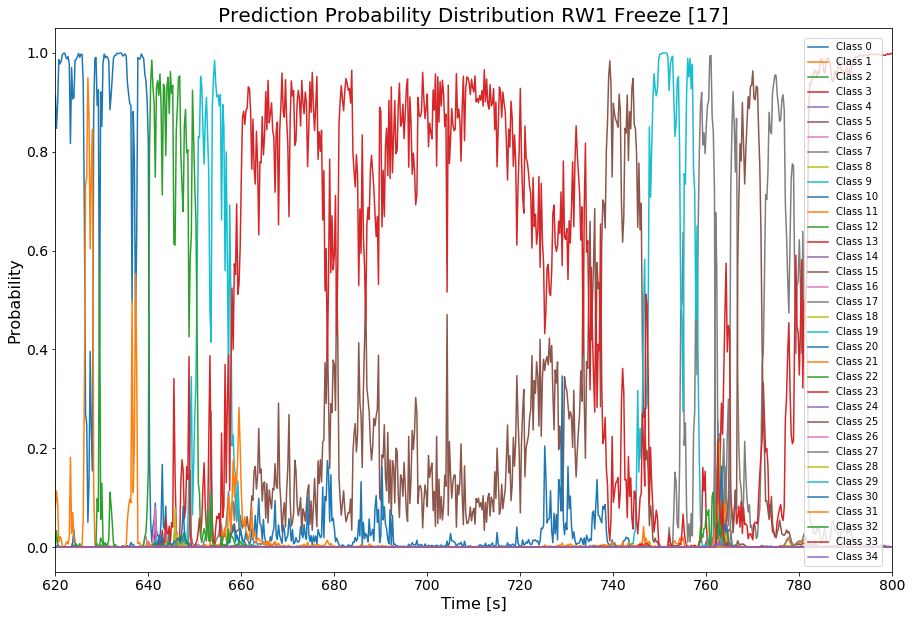

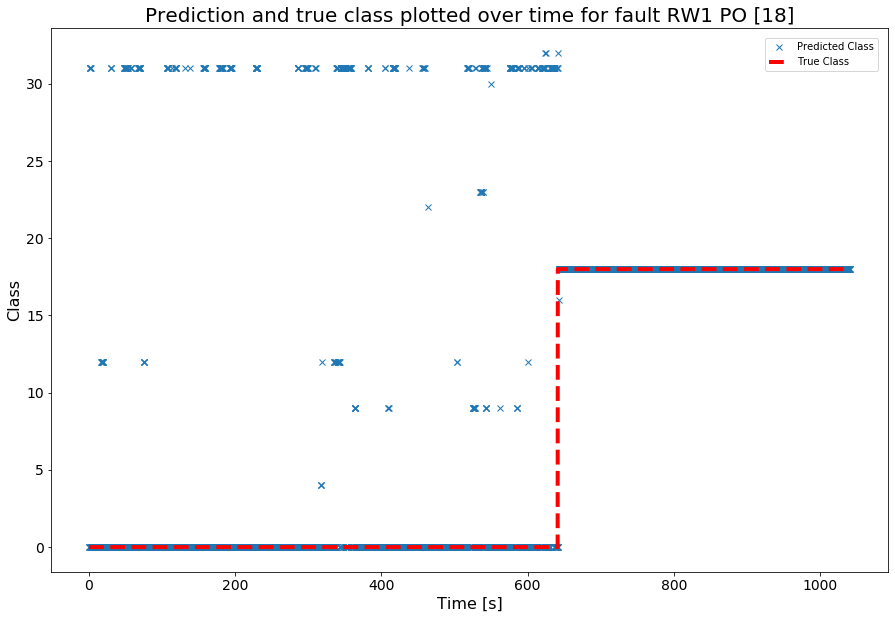

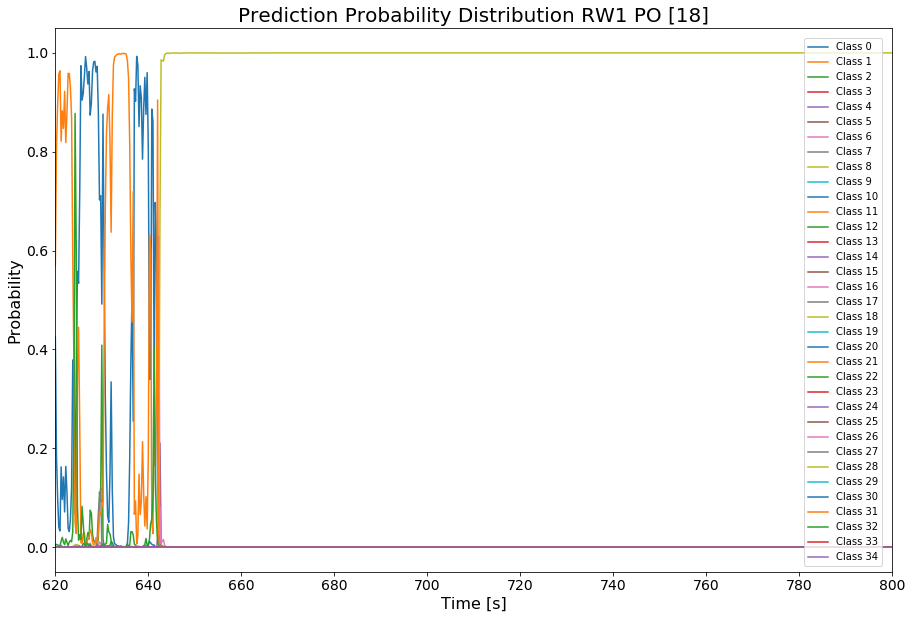

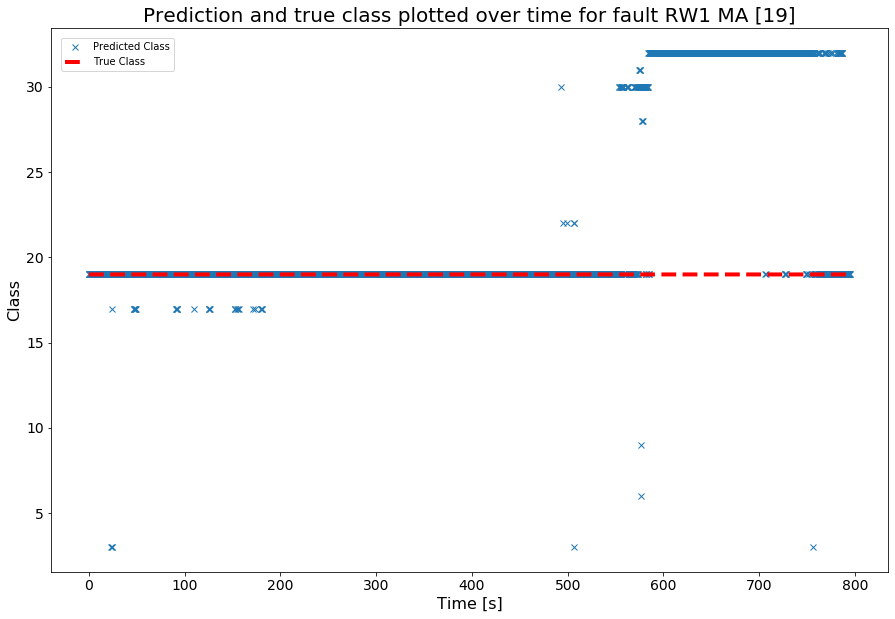

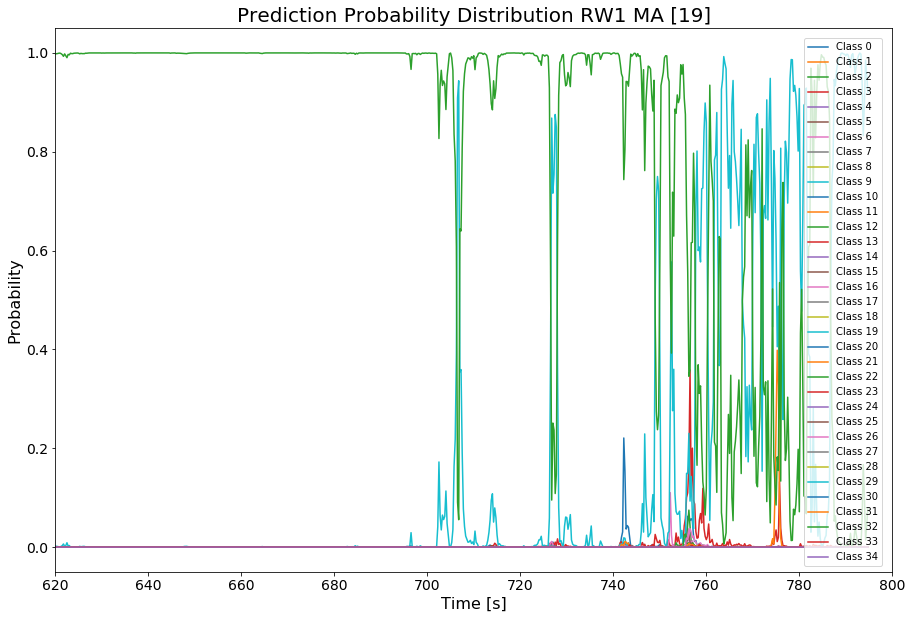

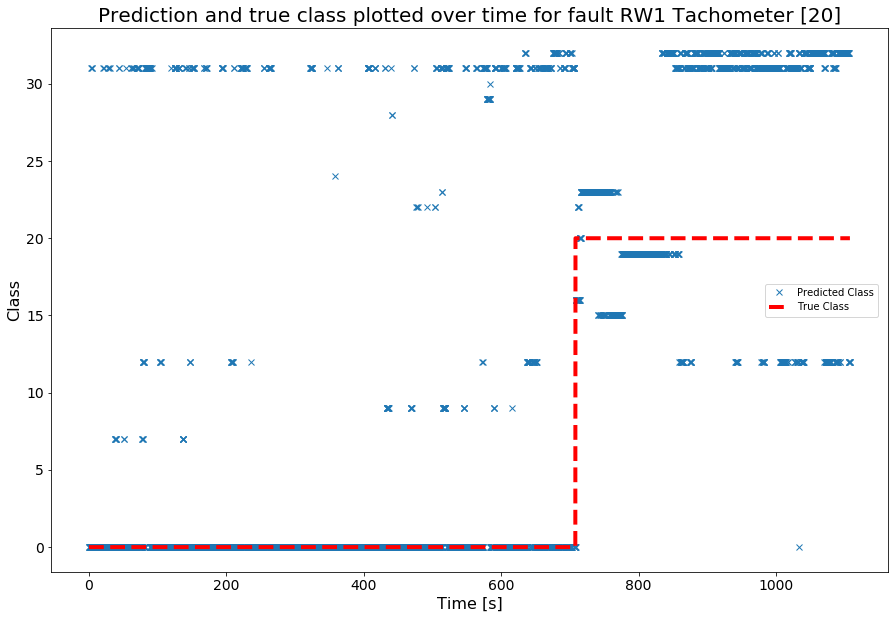

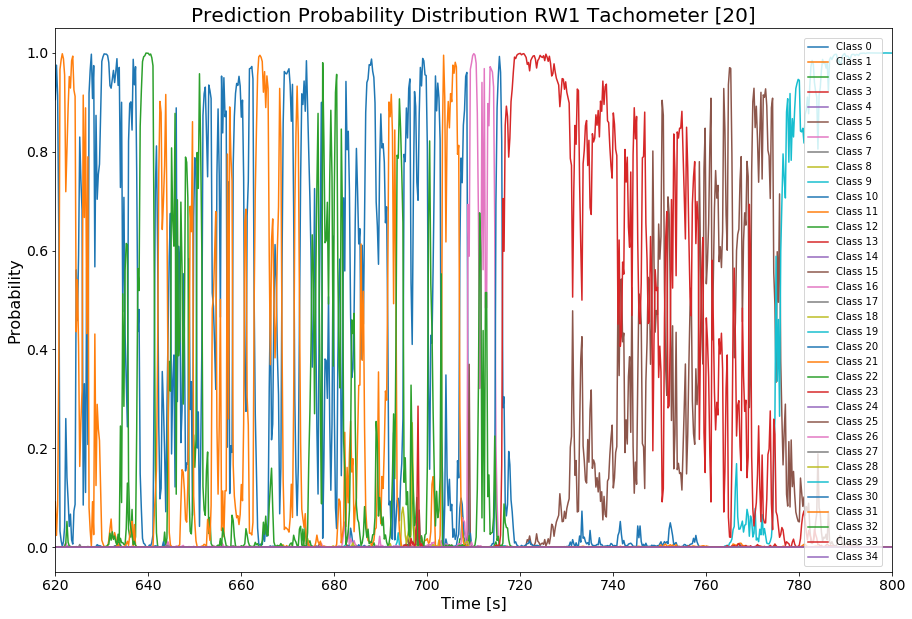

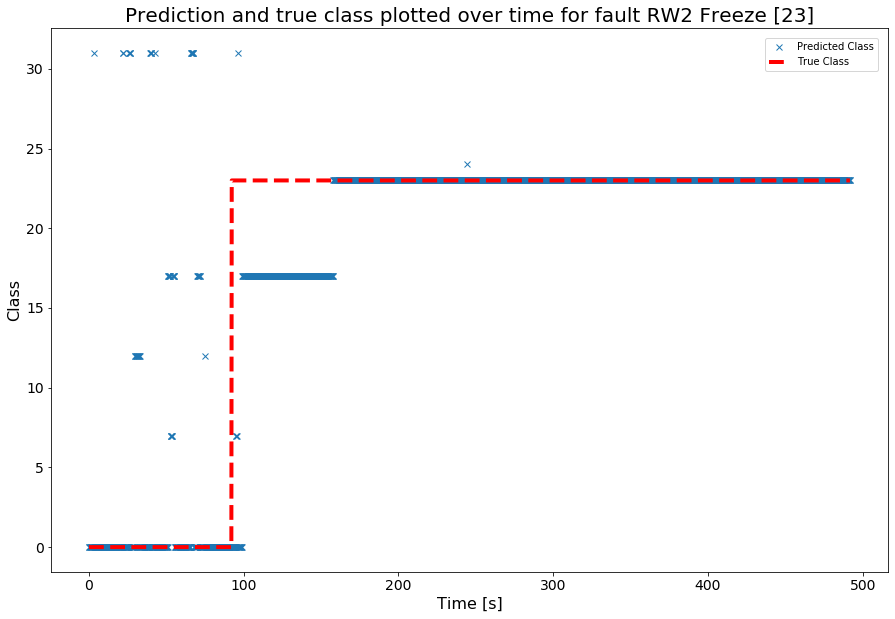

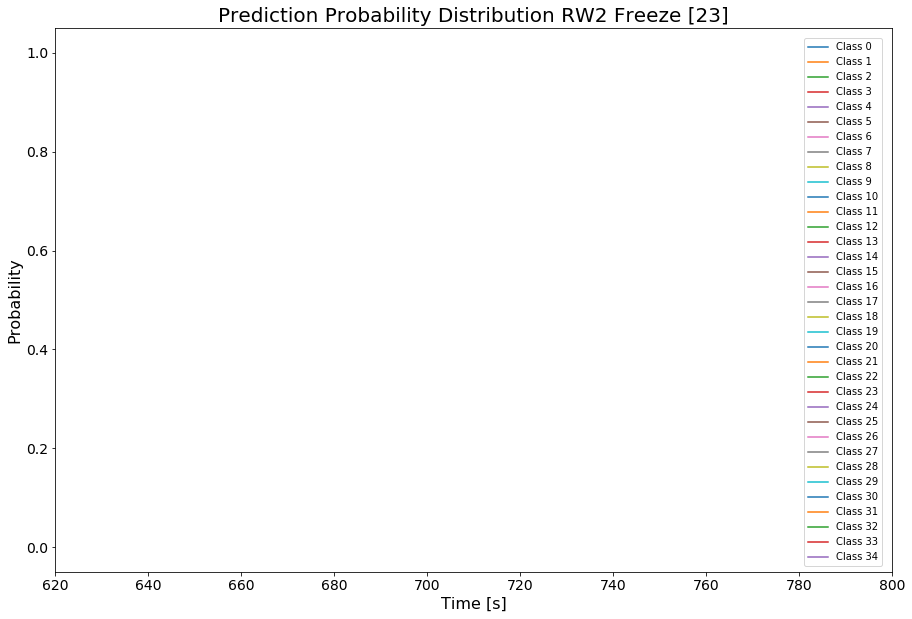

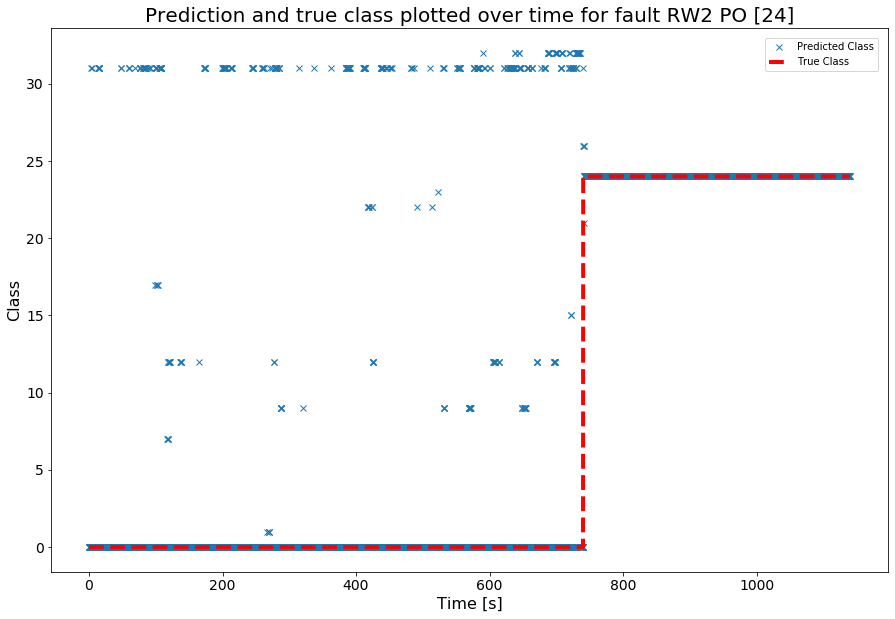

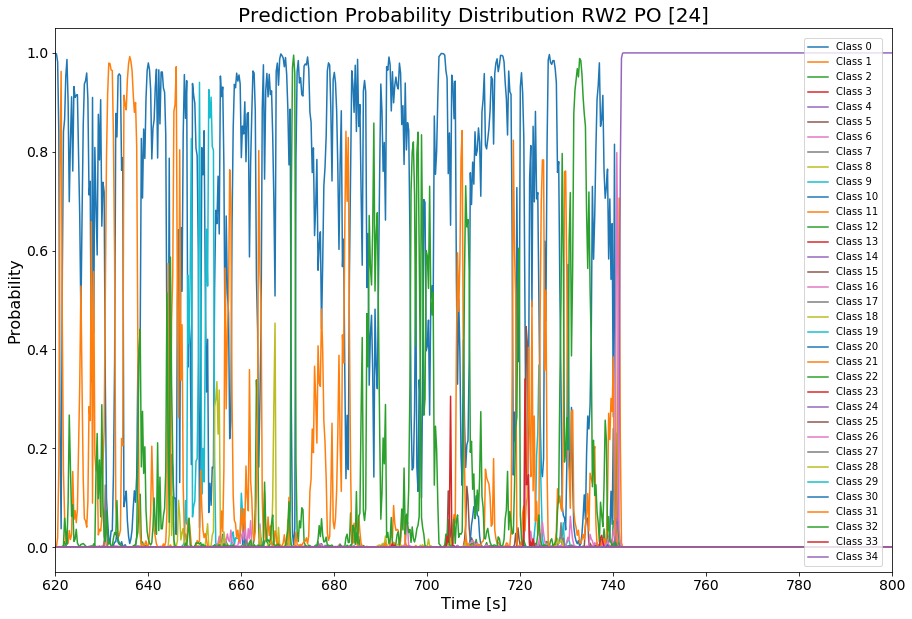

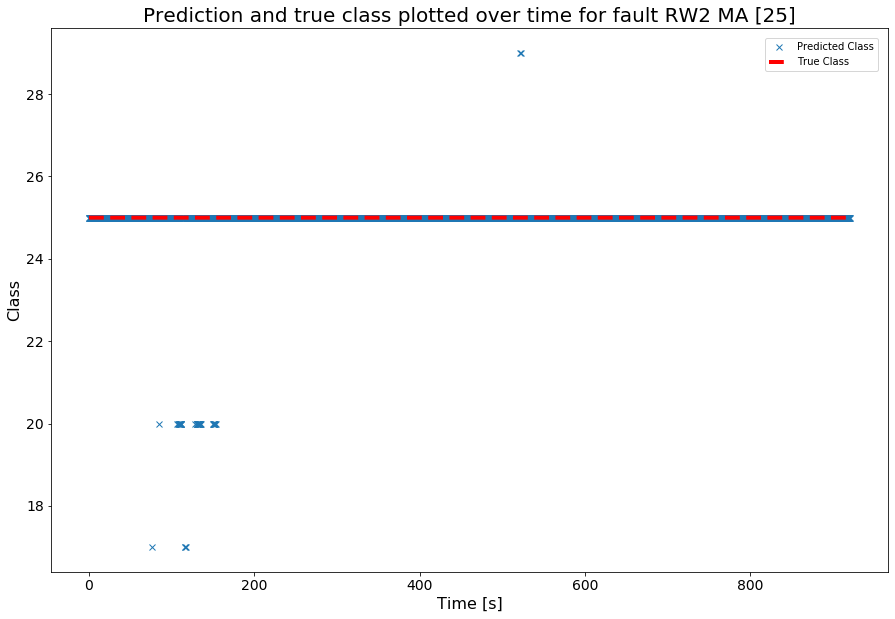

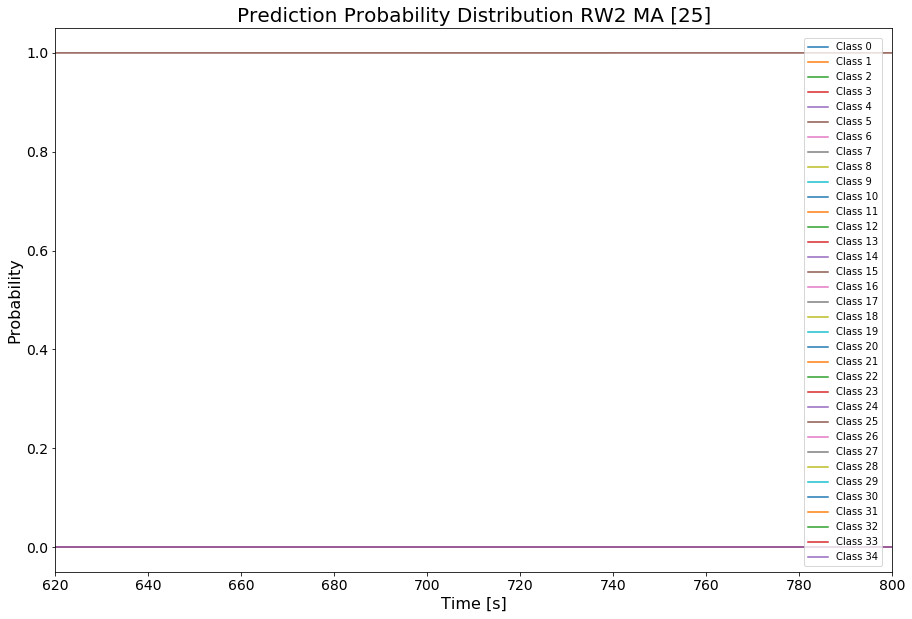

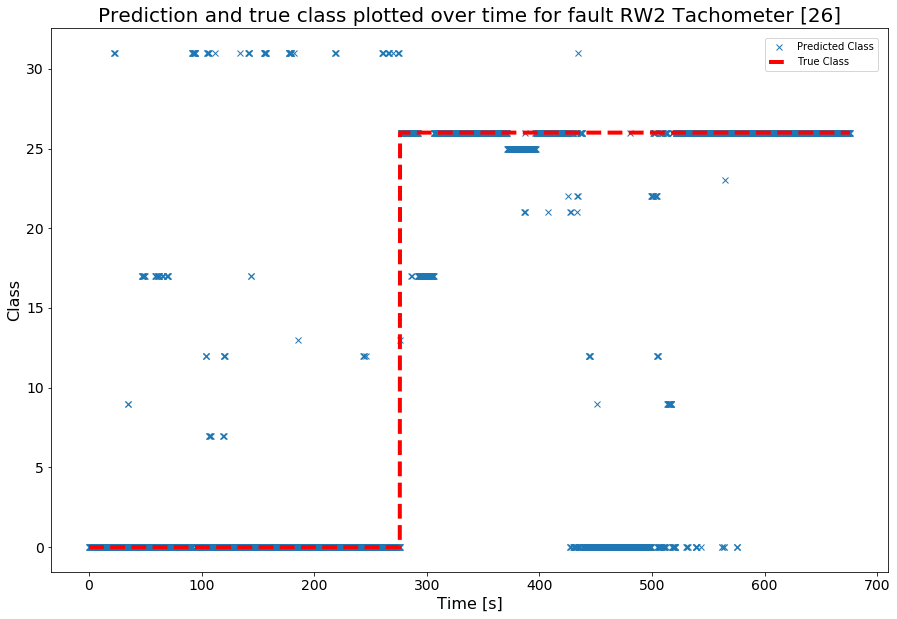

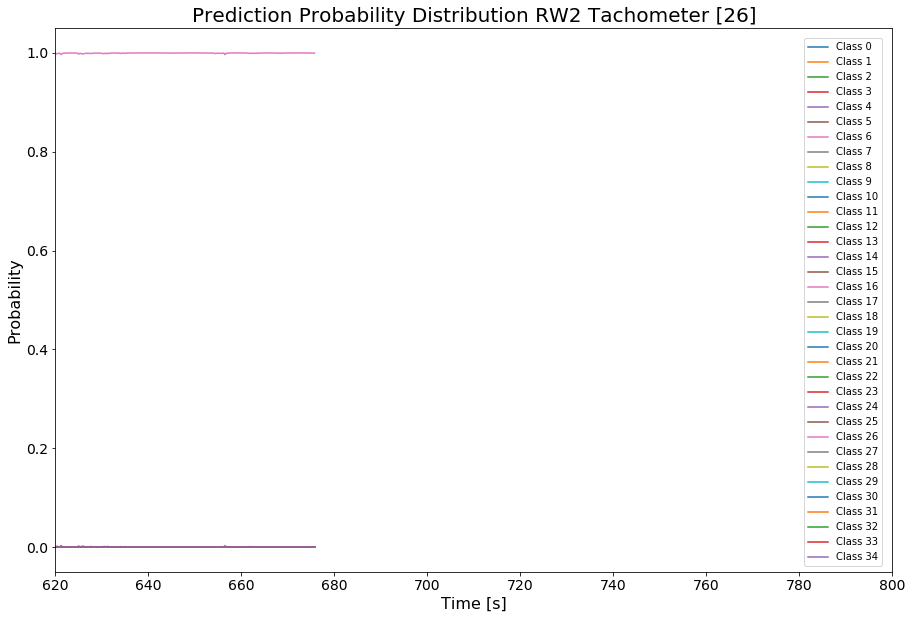

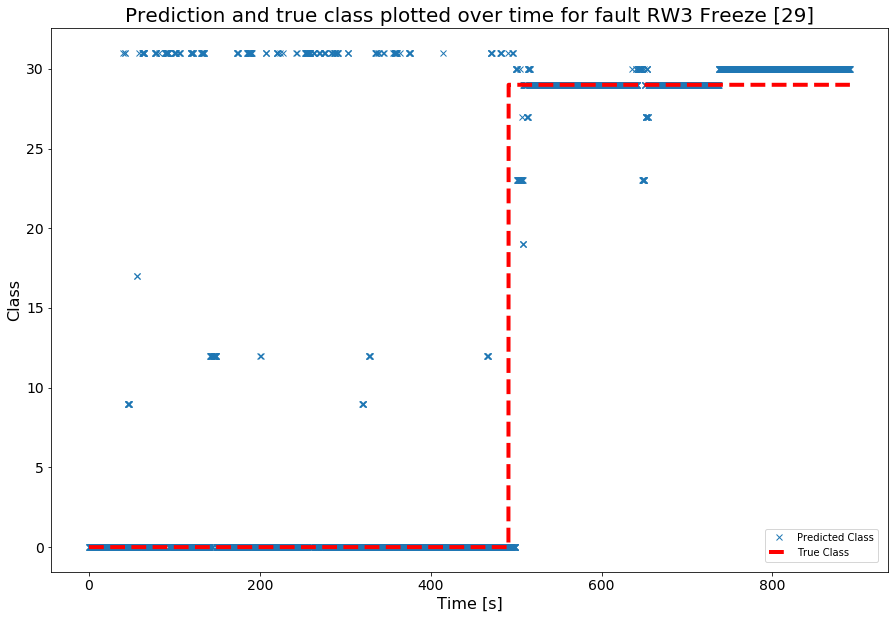

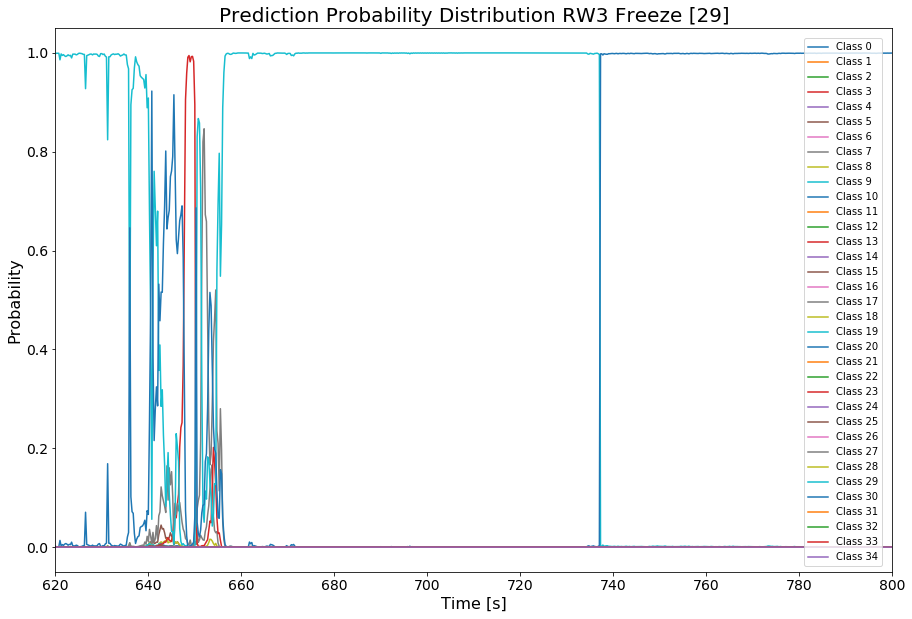

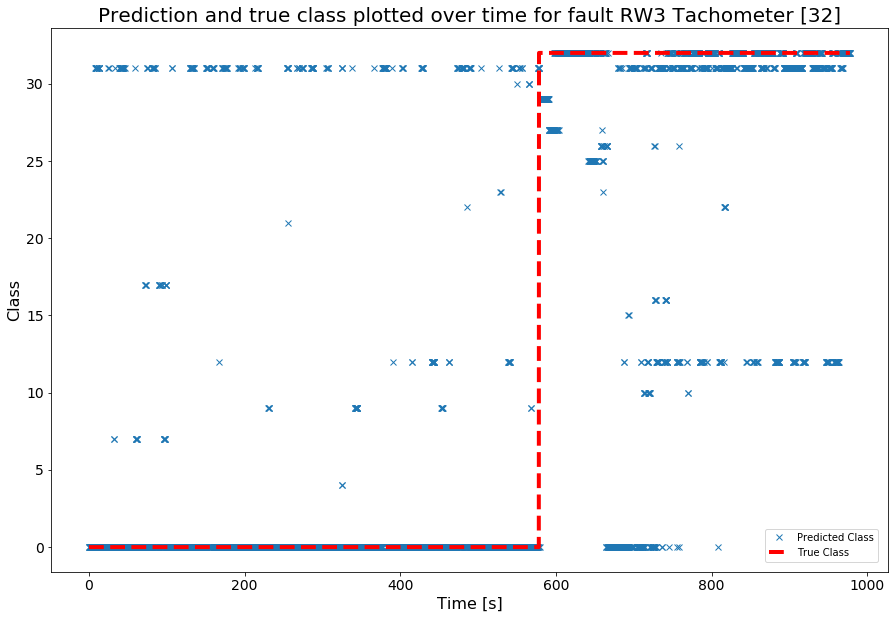

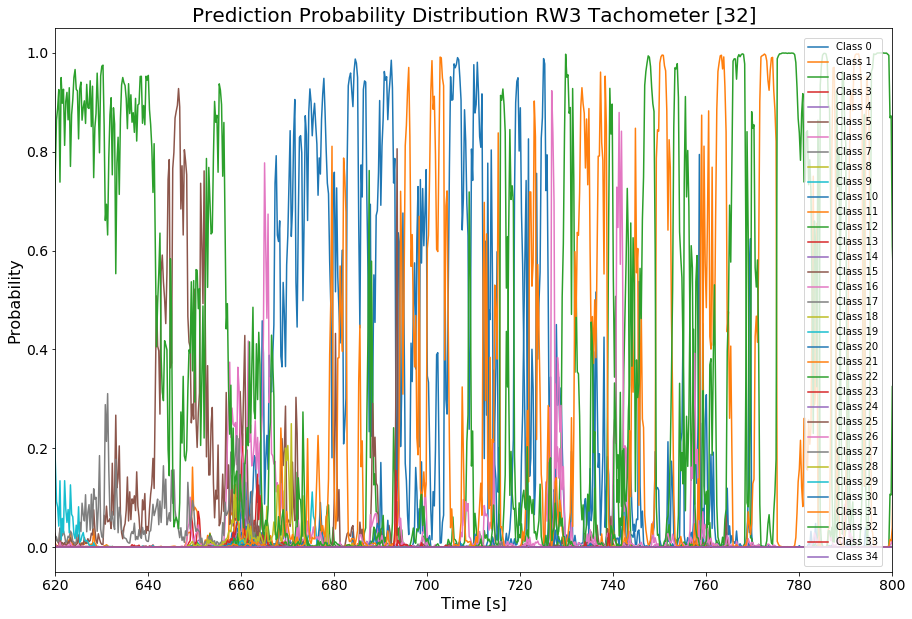

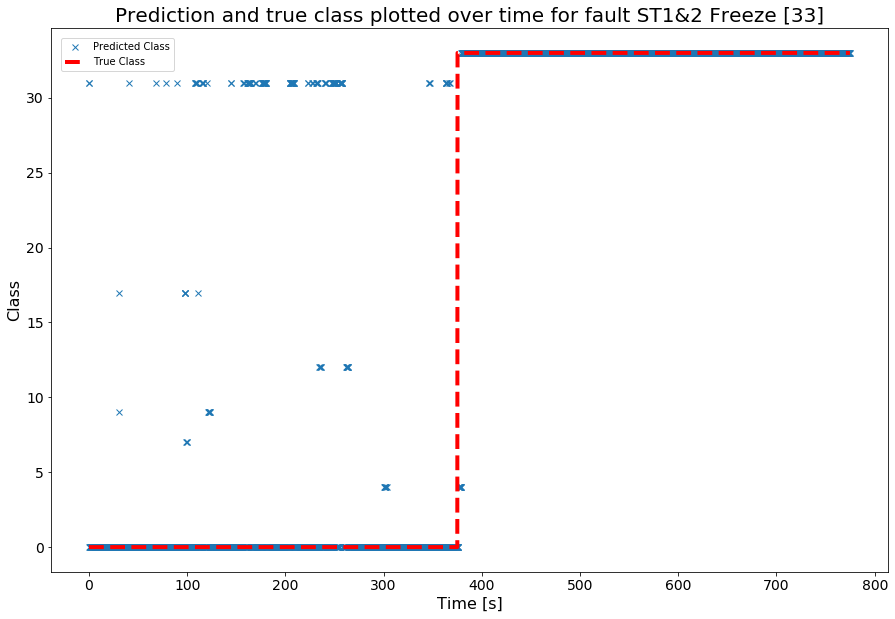

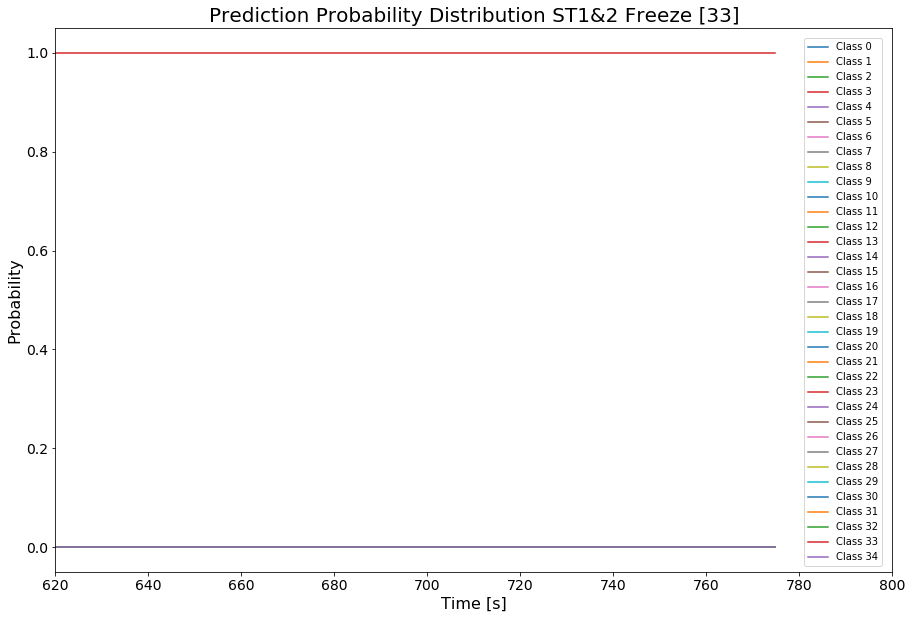

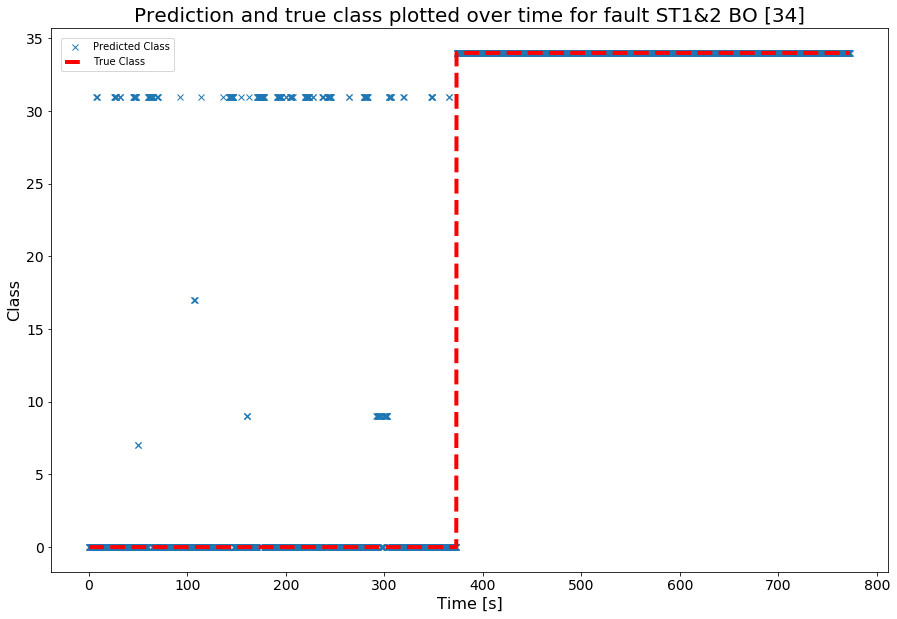

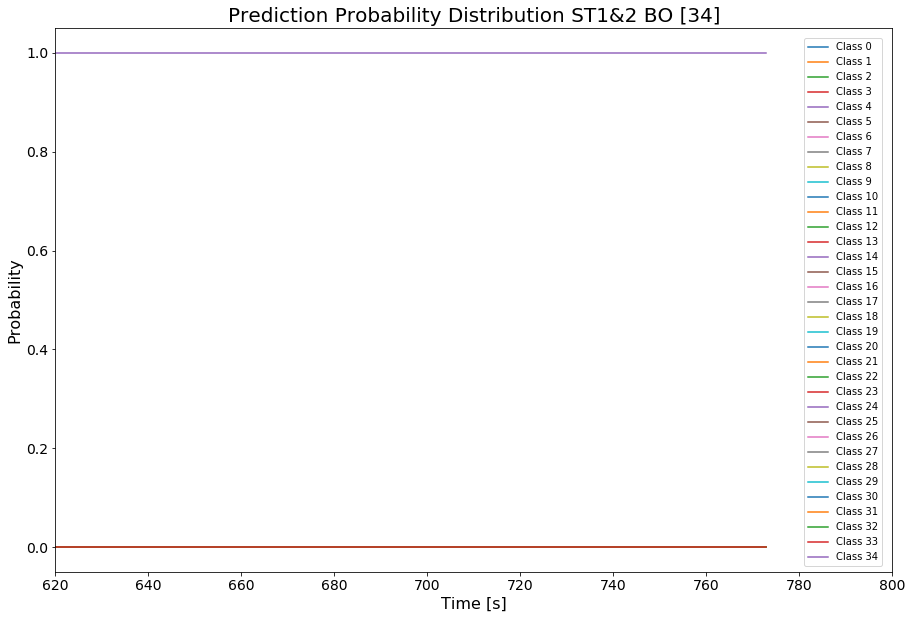

In [0]:
start = 0
pltnum = 0

for idx in range(0,len(y_pred)):
  if ((y_true[idx] != y_true[idx-1]) and (y_true[idx-1] != 0) and idx!= 0):
    # End of the simulation
    fig, ax = plt.subplots()
    plt.plot(np.arange(0, (idx-1-start)*0.25, 0.25), y_pred[start:idx-1], 'x', label='Predicted Class')
    plt.plot(np.arange(0, (idx-1-start)*0.25, 0.25), y_true[start:idx-1],'--r' ,label='True Class', linewidth=4)
    plt.title("Prediction and true class plotted over time for fault {0} [{1}]".format(true_class[idx-1],y_true[idx-1]),
              fontsize=20)
    plt.xlabel("Time [s]", fontsize=16)
    plt.ylabel("Class", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    fig.set_size_inches(15,10)
    plt.legend(loc=0, borderaxespad=1)

    fig, ax = plt.subplots()
    for k in range(0,35):
      plt.plot(np.arange(0, (idx-1-start)*0.25, 0.25), predictions_test[start:idx-1,k], label='Class {0}'.format(k))
      fig.set_size_inches(15,10)
      plt.legend(loc=0, borderaxespad=1)
      plt.title("Prediction Probability Distribution {0} [{1}]".format(true_class[idx-1],y_true[idx-1]), fontsize=20)
      plt.xlabel("Time [s]", fontsize=16)
      plt.ylabel("Probability", fontsize=16)
      plt.xticks(fontsize=14)
      plt.yticks(fontsize=14)
      plt.xlim((620,800))
    start = idx
    pltnum = pltnum+1
  if pltnum >= 35:
    break

In [0]:
precisions, recall, f1_score, _ = precision_recall_fscore_support(y_true[0:len(y_pred)], y_pred)
print(np.mean(recall))
score = dict()
header = 'Class, Precision, Recall, f1-score\n'
with open(Path('gdrive/My Drive/data/result/score_{0}.txt'.format(NAME)), 'w') as f:
  f.write(header)
  for k in np.arange(len(precisions)):
    f.write("{0}, {1}, {2}, {3}\n".format(fault_dict[INCLUDE[k]], precisions[k], recall[k], f1_score[k]))
for k in np.arange(len(precisions)):
  print("{0:14s}:".format(fault_dict[INCLUDE[k]]), end=" ")
  print("{0:.2f}".format(recall[k]))

0.6973630879695489
Nominal       : 0.86
ST1 Freeze    : 0.97
ST1 BO        : 1.00
ST1 MA        : 0.29
ST2 Freeze    : 0.99
ST2 BO        : 1.00
ST2 MA        : 0.98
MT1 Freeze    : 0.85
MT1 BO        : 1.00
MT1 MA        : 0.97
MT2 Freeze    : 0.90
MT2 BO        : 1.00
MT2 MA        : 0.95
GPS Freeze    : 0.99
GPS BO        : 1.00
RW1 Friction  : 0.99
RW1 Electrical: 0.98
RW1 Freeze    : 0.52
RW1 PO        : 1.00
RW1 MA        : 0.74
RW1 Tachometer: 0.00
RW2 Friction  : 0.00
RW2 Electrical: 0.00
RW2 Freeze    : 0.83
RW2 PO        : 1.00
RW2 MA        : 0.99
RW2 Tachometer: 0.68
RW3 Friction  : 0.00
RW3 Electrical: 0.00
RW3 Freeze    : 0.53
RW3 PO        : 0.00
RW3 MA        : 0.00
RW3 Tachometer: 0.40
ST1&2 Freeze  : 0.99
ST1&2 BO      : 1.00


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
